**Table of Contents** <br>
* [1. Imports](#1)
* [2. Import Datasets](#2)
* [3. Data Description](#3)
* [4. Data Exploration](#4)
* [5. Data Cleaning and Preprocessing](#5)
* [6. Feature Engineering](#6)
* [7. Train Test Split](#7)
* [8. Encoding non-metric features](#8)
* [9. Normalizing metric features](#9)
* [10. Feature Importance](#10)
* [11. Models](#11)
* [12. Train Test Split](#12)
* [13. Improving Results - Hyperparameter Tunning](#13)
* [14. Stacking](#14)
* [15. ROC Curves](#15)
* [16. Candidate Models](#16)
* [17. Final Model](#17)

<hr>
<a class="anchor" id="1">
    
# 1. Imports
    
</a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import glob
from math import ceil
import scipy.stats as stats
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
#!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from datetime import datetime
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifierCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

<hr>
<a class="anchor" id="2">
    
# 2. Importing datasets
    
</a>

In [2]:
train_demo = pd.read_excel('train_demo.xlsx', sheet_name='Sheet1')
# demo - the training set for demographic data and the target
train_habits = pd.read_excel('train_habits.xlsx', sheet_name='Sheet1')
# habits - the training set for health related data
train_health = pd.read_excel('train_health.xlsx', sheet_name='Sheet1')
# health - the training set for habits related data

train_full = pd.concat([train_demo, train_habits, train_health], axis =1)

In [3]:
train_full = train_full.loc[:,~train_full.columns.duplicated()].copy()
#setting 'Disease' on last column to facilitate 
train_full = train_full.reindex(columns = [col for col in train_full.columns if col != 'Disease'] + ['Disease'])

#Setting 'PatientID' as the index of our train dataset
train_full.set_index("PatientID", inplace = True) 

#Droping the column 'Name' - Train
train_full.drop(['Name'],axis=1,inplace=True)

train_original = train_full.copy()
train_full.head(2)

,Birth_Year,Region,Education,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Disease
PatientID,,,,,,,,,,,,,,,,,
1167,1965,London,High School Incomplete (10th to 11th grade),No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.,1
1805,1969,South West,High School Incomplete (10th to 11th grade),No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.,1


In [4]:
test_demo = pd.read_excel('test_demo.xlsx', sheet_name='Sheet1')
# demo - the test set for demographic data and the target
test_habits = pd.read_excel('test_habits.xlsx', sheet_name='Sheet1')
# habits - the test set for health related data
test_health = pd.read_excel('test_health.xlsx', sheet_name='Sheet1')
# health - the training set for habits related data

test_full = pd.concat([test_demo, test_habits, test_health], axis =1)

In [5]:
test_full = test_full.loc[:,~test_full.columns.duplicated()].copy()

#Setting 'PatientID' as the index of our train dataset
test_full.set_index("PatientID", inplace = True) 

#Droping the column 'Name' - Test
test_full.drop(['Name'],axis=1,inplace=True)

test_original = test_full.copy()
test_full.head(2)

,Birth_Year,Region,Education,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,,,,,,,,,
1343,1970,East Midlands,Elementary School (1st to 9th grade),Yes,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters,172,80,203,172,20,2,Not sure,I have/had pregnancy diabetes or borderline di...
1727,1966,Yorkshire and the Humber,University Complete (3 or more years),No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,171,80,225,130,21,0,Not sure,I do have diabetes


In [6]:
train_full['Disease'].value_counts()

1    411
0    389
Name: Disease, dtype: int64

In [7]:
train_full.duplicated().sum()

0

<hr>
<a class="anchor" id="3">
    
# 3. Data Description
    
</a>

In [8]:
train_full.columns


Index(['Birth_Year', 'Region', 'Education', 'Smoking_Habit', 'Drinking_Habit',
       'Exercise', 'Fruit_Habit', 'Water_Habit', 'Height', 'Weight',
       'High_Cholesterol', 'Blood_Pressure', 'Mental_Health',
       'Physical_Health', 'Checkup', 'Diabetes', 'Disease'],
      dtype='object')

In [9]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Birth_Year        800 non-null    int64 
 1   Region            800 non-null    object
 2   Education         787 non-null    object
 3   Smoking_Habit     800 non-null    object
 4   Drinking_Habit    800 non-null    object
 5   Exercise          800 non-null    object
 6   Fruit_Habit       800 non-null    object
 7   Water_Habit       800 non-null    object
 8   Height            800 non-null    int64 
 9   Weight            800 non-null    int64 
 10  High_Cholesterol  800 non-null    int64 
 11  Blood_Pressure    800 non-null    int64 
 12  Mental_Health     800 non-null    int64 
 13  Physical_Health   800 non-null    int64 
 14  Checkup           800 non-null    object
 15  Diabetes          800 non-null    object
 16  Disease           800 non-null    int64 
dtypes: int64(8),

In [10]:
#defining metric and non-metric features

non_metric = ["Region", "Education", "Smoking_Habit", "Drinking_Habit", "Exercise", "Fruit_Habit", "Water_Habit","Checkup","Diabetes","Disease"]
metric = train_full.columns.drop(non_metric).to_list()

In [11]:
# Getting the descriptive statistics for all variables
train_full[metric].describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Birth_Year,800.0,1966.04375,15.421872,1855.0,1961.00,1966.0,1974.0,1993.0
Height,800.0,167.80625,7.976888,151.0,162.00,167.0,173.0,180.0
Weight,800.0,67.82750,12.113470,40.0,58.00,68.0,77.0,97.0
High_Cholesterol,800.0,249.32250,51.566631,130.0,213.75,244.0,280.0,568.0
Blood_Pressure,800.0,131.05375,17.052693,94.0,120.00,130.0,140.0,200.0
Mental_Health,800.0,17.34500,5.385139,0.0,13.00,18.0,21.0,29.0
Physical_Health,800.0,4.55875,5.449189,0.0,0.00,3.0,7.0,30.0


In [12]:
train_full[non_metric].describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Region,800,10,East Midlands,154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,787,6,University Complete (3 or more years),239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smoking_Habit,800,2,No,673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drinking_Habit,800,3,I usually consume alcohol every day,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise,800,2,No,536,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fruit_Habit,800,5,Less than 1. I do not consume fruits every day.,452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water_Habit,800,3,Between one liter and two liters,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checkup,800,4,More than 3 years,429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Diabetes,800,4,Neither I nor my immediate family have diabetes.,392,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disease,800.0,NaN,NaN,NaN,0.51375,0.500124,0.0,0.0,1.0,1.0,1.0


In [13]:
Region = train_full.groupby(['Region']).size()
Region

Region
East Midlands               154
East of England              80
LONDON                        5
London                      136
North East                   22
North West                   59
South East                   84
South West                  107
West Midlands                89
Yorkshire and the Humber     64
dtype: int64

In [14]:
Region = test_full.groupby(['Region']).size()
Region

Region
East Midlands               32
East of England             31
London                      50
North East                   9
North West                  13
South East                  22
South West                  22
West Midlands               30
Yorkshire and the Humber    16
dtype: int64

In [15]:
train_full.loc[train_full['Region'] ==  'LONDON', 'Region'] = "London"
train_full['Region'].value_counts()

East Midlands               154
London                      141
South West                  107
West Midlands                89
South East                   84
East of England              80
Yorkshire and the Humber     64
North West                   59
North East                   22
Name: Region, dtype: int64

In [16]:
#defining metric and non-metric features

non_metric = ["Region", "Education", "Smoking_Habit", "Drinking_Habit", "Exercise", "Fruit_Habit", "Water_Habit","Checkup","Diabetes","Disease"]
metric = train_full.columns.drop(non_metric).to_list()

<hr>
<a class="anchor" id="4">
    
# 4. Data Exploration
    
</a>

## Metric Variables

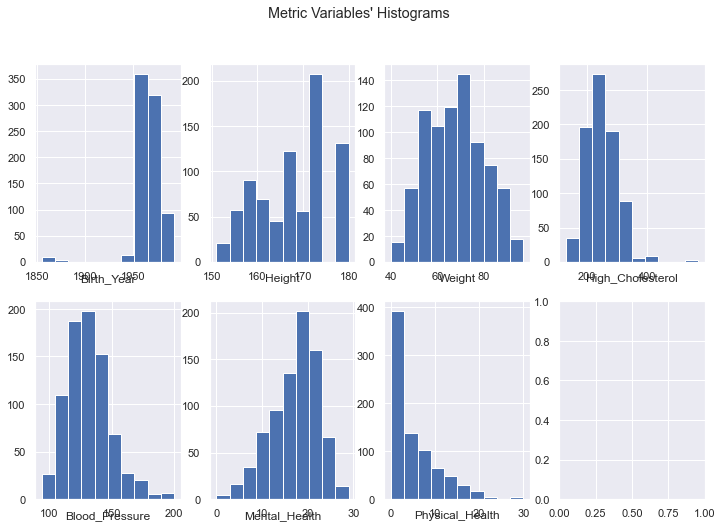

In [17]:
# All metric variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric) / 2), figsize=(12, 8))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric): 
    ax.hist(train_full[feat])
    ax.set_title(feat, y=-0.13) 
    
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Histograms"

plt.suptitle(title)

plt.show()

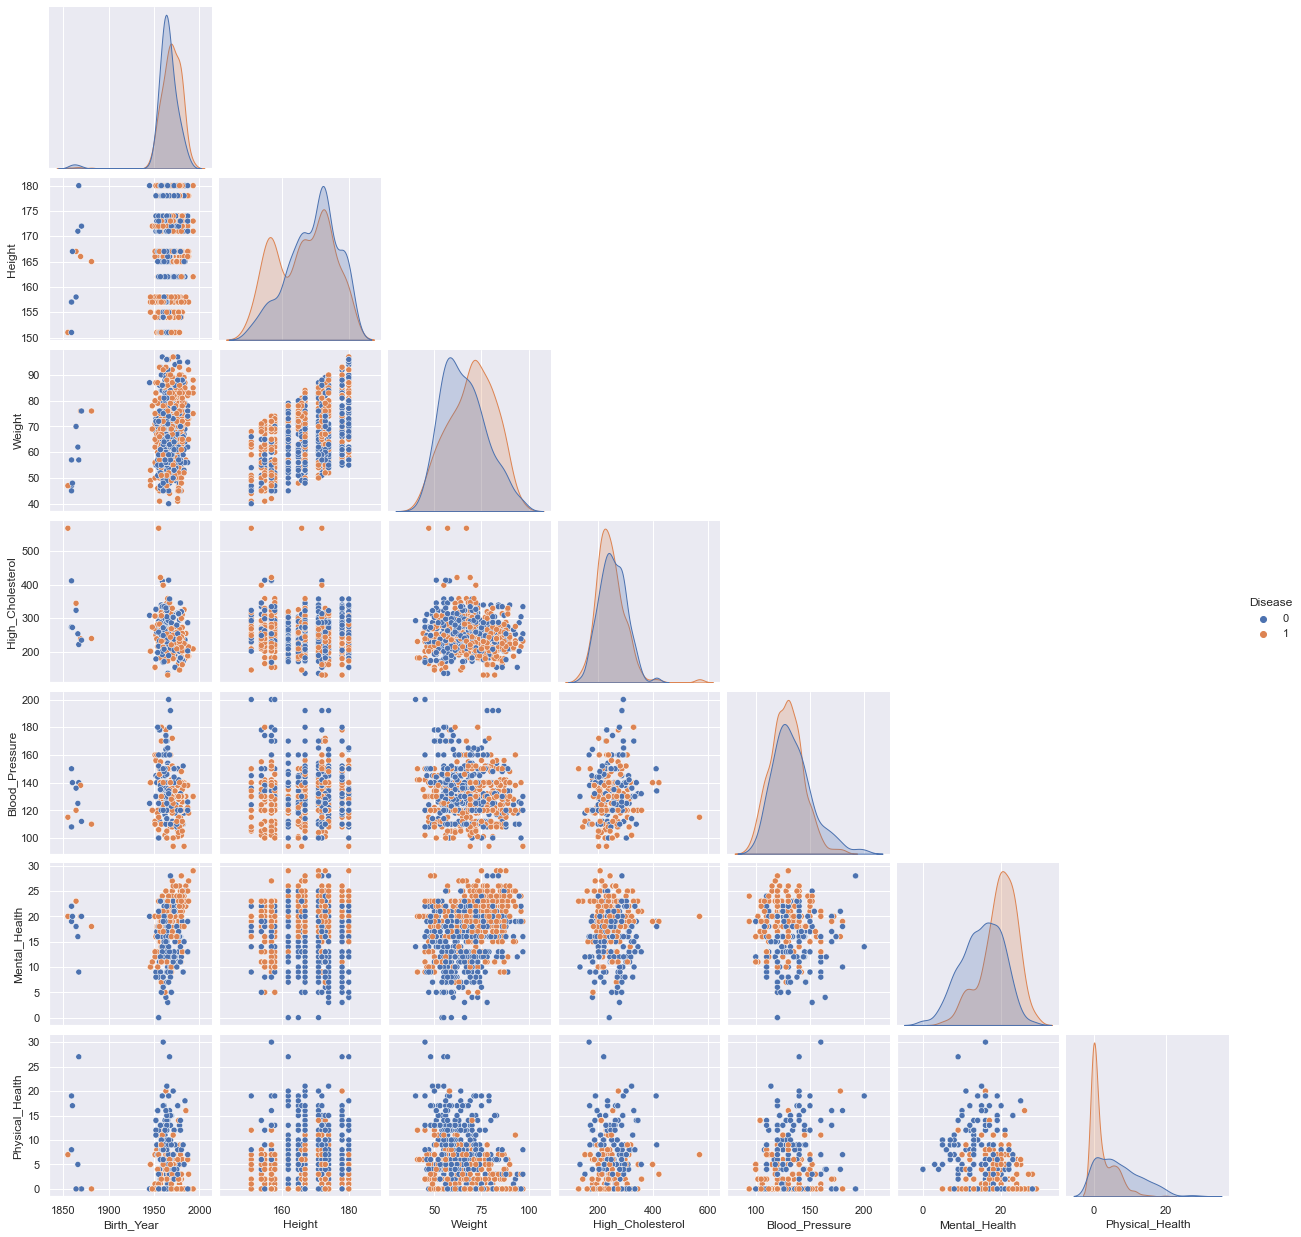

In [18]:
sns.pairplot(train_full, corner = True, hue = 'Disease')


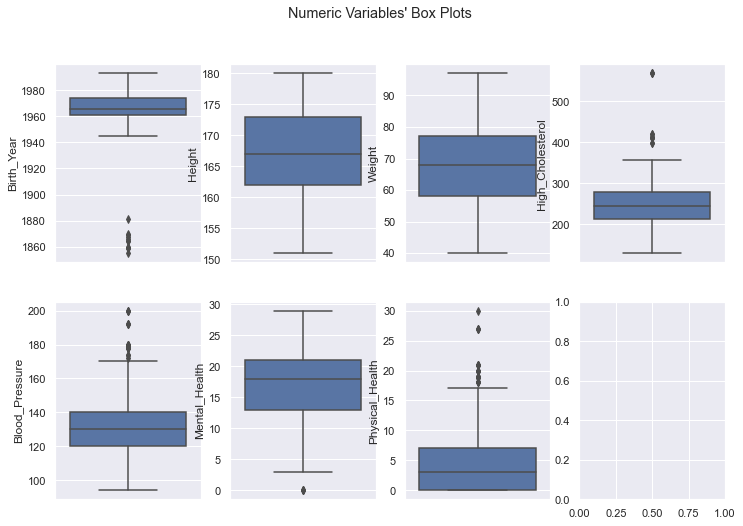

In [19]:
# All Numeric Variables' Boxplot in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric) / 2), figsize=(12, 8))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric): # Notice the zip() function and flatten() method
    sns.boxplot(y=train_full[feat],ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

## Non-Metric Variables
### Absolute Frequencies

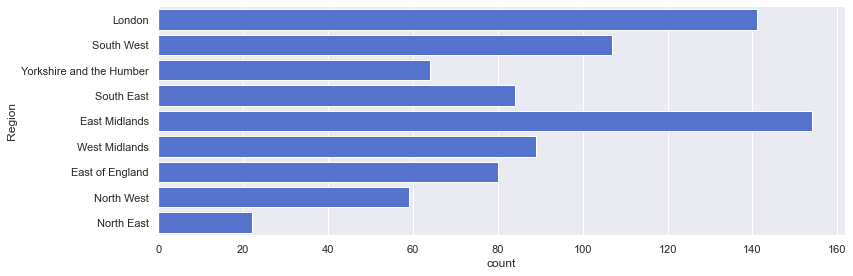

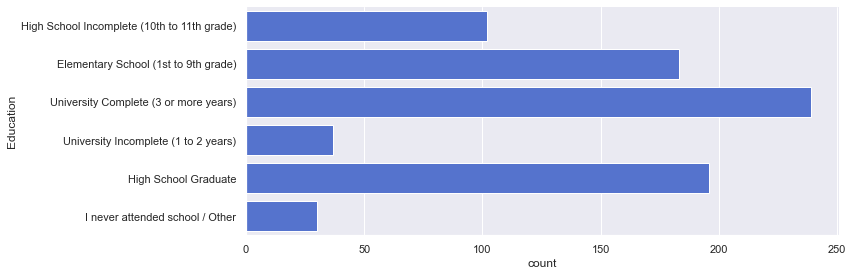

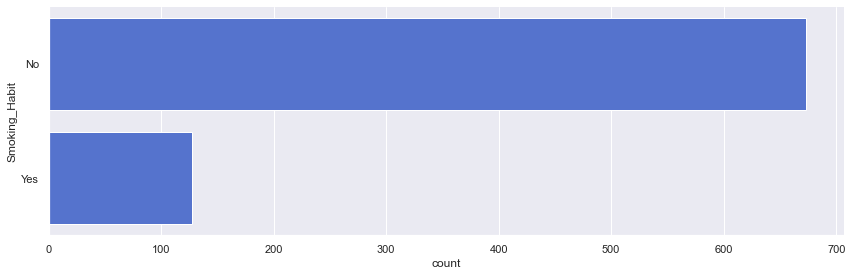

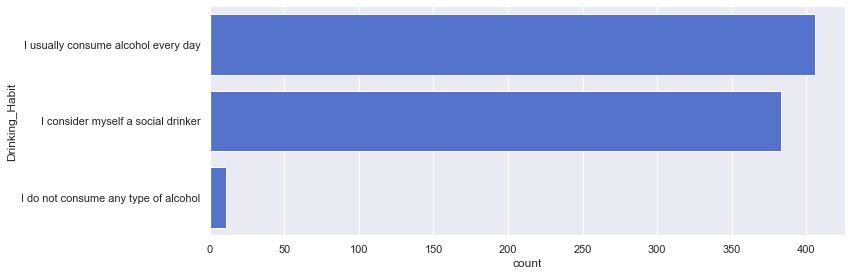

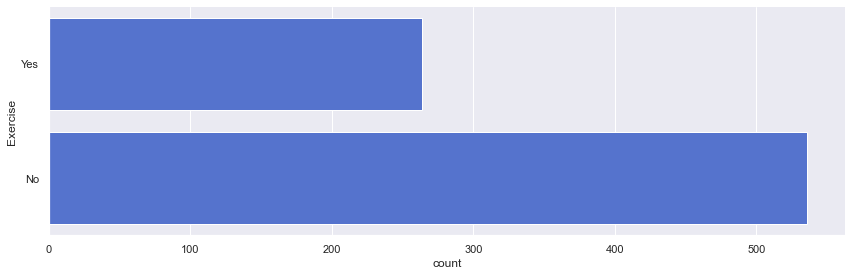

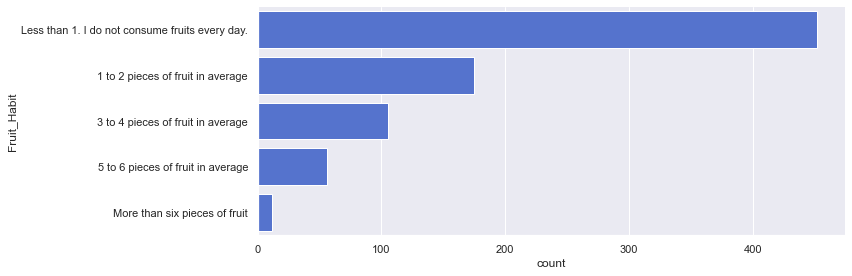

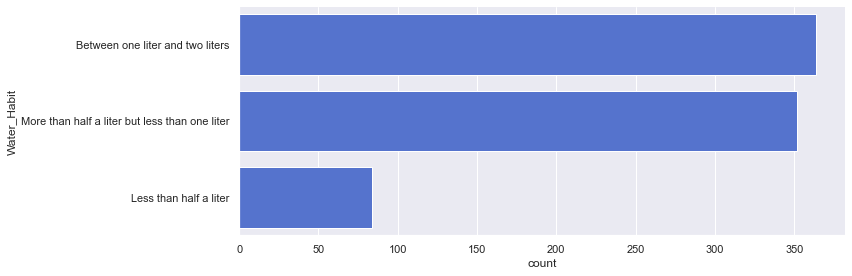

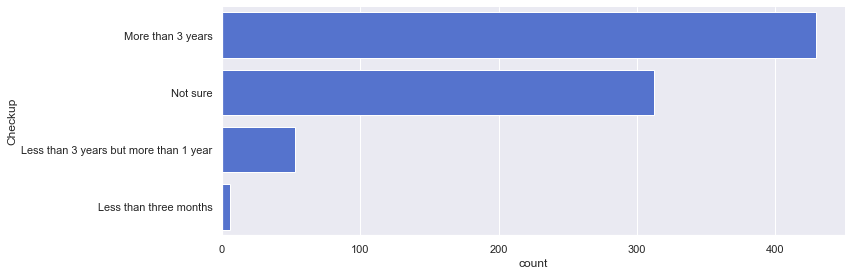

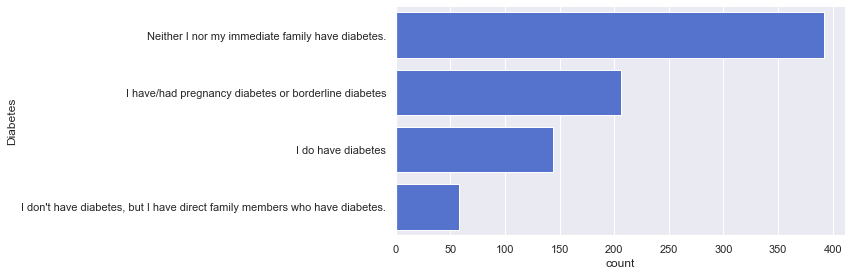

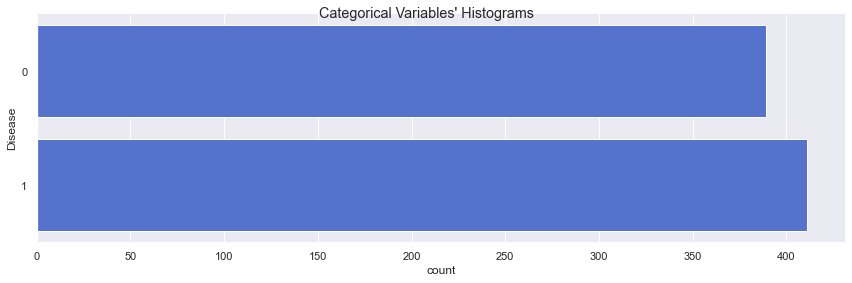

In [20]:
cat_var = train_full[non_metric]
cat_var_list = train_full[non_metric].columns.to_list()

for i in range(len(cat_var_list)):
    sns.catplot(data=train_full,y=cat_var_list[i], color = "royalblue", kind="count",height=4, aspect=3)

title = "Categorical Variables' Histograms"

plt.suptitle(title)

plt.show()

<hr>
<a class="anchor" id="5">
    
# 5. Data Cleaning and Preprocessing
    
</a>

## Imputing missing values

In [21]:
print("Test Dataset:", "\n",train_full.isna().sum())
print("\n","Test Dataset:", "\n",test_full.isna().sum())

Test Dataset: 
 Birth_Year           0
Region               0
Education           13
Smoking_Habit        0
Drinking_Habit       0
Exercise             0
Fruit_Habit          0
Water_Habit          0
Height               0
Weight               0
High_Cholesterol     0
Blood_Pressure       0
Mental_Health        0
Physical_Health      0
Checkup              0
Diabetes             0
Disease              0
dtype: int64

 Test Dataset: 
 Birth_Year          0
Region              0
Education           0
Smoking_Habit       0
Drinking_Habit      0
Exercise            0
Fruit_Habit         0
Water_Habit         0
Height              0
Weight              0
High_Cholesterol    0
Blood_Pressure      0
Mental_Health       0
Physical_Health     0
Checkup             0
Diabetes            0
dtype: int64


In [22]:
train_full['Education'].value_counts(dropna=False)

University Complete (3 or more years)          239
High School Graduate                           196
Elementary School (1st to 9th grade)           183
High School Incomplete (10th to 11th grade)    102
University Incomplete (1 to 2 years)            37
I never attended school / Other                 30
NaN                                             13
Name: Education, dtype: int64

In [23]:
train_full['Education'].mode()
train_full['Education'].fillna('University Complete (3 or more years)', inplace=True)

In [24]:
train_full['Education'].value_counts(dropna=False)
#There are no more missing values on this variable

University Complete (3 or more years)          252
High School Graduate                           196
Elementary School (1st to 9th grade)           183
High School Incomplete (10th to 11th grade)    102
University Incomplete (1 to 2 years)            37
I never attended school / Other                 30
Name: Education, dtype: int64

## Handling Outliers

### IQR method

In [25]:
q25 = train_full.quantile(.25)
q75 = train_full.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters1 = []
for i in metric:
    llim = lower_lim[i]
    ulim = upper_lim[i]
    filters1.append(train_full[i].between(llim, ulim, inclusive=True))

filters1 = pd.Series(np.all(filters1, 0),index=train_full.index)
df_1 = train_full[filters1]

print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / train_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9225


<ipython-input-25-15d73c93dce6>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q25 = train_full.quantile(.25)
<ipython-input-25-15d73c93dce6>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q75 = train_full.quantile(.75)
<ipython-input-25-15d73c93dce6>:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  filters1.append(train_full[i].between(llim, ulim, inclusive=True))


### Manual Removal

In [26]:
#Removing outliers manually
filters2 = (
    (train_full['Birth_Year'] >= 1925)
    &
    (train_full['High_Cholesterol'] <= 500)
    &
    (train_full['Physical_Health'] <= 25)
)

df_2 = train_full[filters2]

print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / train_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9788


### Combining methods

In [27]:
train_full = train_full[(filters1 | filters2)]
print('Percentage of data kept after removing outliers:', np.round(train_full.shape[0] / train_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9788


<hr>
<a class="anchor" id="6">
    
# 6. Feature Engineering
    
</a>

In [28]:
# Age column (increases readability)
train_full['Age'] = datetime.now().year - train_full['Birth_Year']

# Body mass index column
train_full['BMI'] = round(train_full['Weight'] / (train_full['Height']/100)**2, 2)

train_full.drop(columns='Birth_Year',inplace=True)

<ipython-input-28-d498bfae8831>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_full['Age'] = datetime.now().year - train_full['Birth_Year']
<ipython-input-28-d498bfae8831>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_full['BMI'] = round(train_full['Weight'] / (train_full['Height']/100)**2, 2)
<ipython-input-28-d498bfae8831>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [29]:
# Age column (increases readability)
test_full['Age'] = datetime.now().year - test_full['Birth_Year']

# Body mass index column
test_full['BMI'] = round(test_full['Weight'] / (test_full['Height']/100)**2, 2)

test_full.drop(columns='Birth_Year',inplace=True)

In [30]:
non_metric = ["Region", "Education", "Smoking_Habit", "Drinking_Habit", "Exercise", "Fruit_Habit", "Water_Habit","Checkup","Diabetes","Disease"]
metric = train_full.columns.drop(non_metric).to_list()

non_metric_test = ["Region", "Education", "Smoking_Habit", "Drinking_Habit", "Exercise", "Fruit_Habit", "Water_Habit","Checkup","Diabetes"]
metric_test = test_full.columns.drop(non_metric_test).to_list()

<hr>
<a class="anchor" id="8">
    
# 8. Encoding non-metric variables
    
</a>

## One Hot Enconding - non-metric variables

In [31]:
# Train
scaler = OneHotEncoder()
OneHotEnc = scaler.fit(train_full[non_metric_test])
ohc_feat = OneHotEnc.transform(train_full[non_metric_test])
ohc_feat_names = OneHotEnc.get_feature_names_out()
ohc_train_non_metric = pd.DataFrame(OneHotEnc.transform(train_full[non_metric_test]).toarray(),columns=ohc_feat_names,index=train_full[non_metric_test].index)

In [32]:
# Test
ohc_feat = OneHotEnc.transform(test_full[non_metric_test])
ohc_feat_names = OneHotEnc.get_feature_names_out()
ohc_test_non_metric = pd.DataFrame(OneHotEnc.transform(test_full[non_metric_test]).toarray(),columns=ohc_feat_names,index=test_full[non_metric_test].index)

<hr>
<a class="anchor" id="9">
    
# 9. Normalizing metric variables
    
</a>

In [33]:
df_minmax_train = train_full[metric].copy()
df_minmax_test = test_full[metric].copy()

In [34]:
scaler = MinMaxScaler().fit(df_minmax_train)

In [35]:
# Train
X_train_num_scaled = scaler.transform(df_minmax_train)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = df_minmax_train.columns).set_index(df_minmax_train.index)

In [36]:
# Train
min_max_X_train = pd.DataFrame(scaler.transform(df_minmax_train), columns=df_minmax_train.columns,index=train_full[metric_test].index)

In [37]:
# Test
min_max_X_test = pd.DataFrame(scaler.transform(df_minmax_test),columns=df_minmax_test.columns,index=df_minmax_test.index)

In [38]:
X_train_norm = pd.concat([ohc_train_non_metric, min_max_X_train], axis=1)
# X_val_norm = pd.concat([ohc_val_non_metric, min_max_X_val], axis=1)
X_test_norm = pd.concat([ohc_test_non_metric, min_max_X_test], axis=1)

In [39]:
y_train = train_full['Disease']

<hr>
<a class="anchor" id="10">
    
# 10. Feature Importance
    
</a>

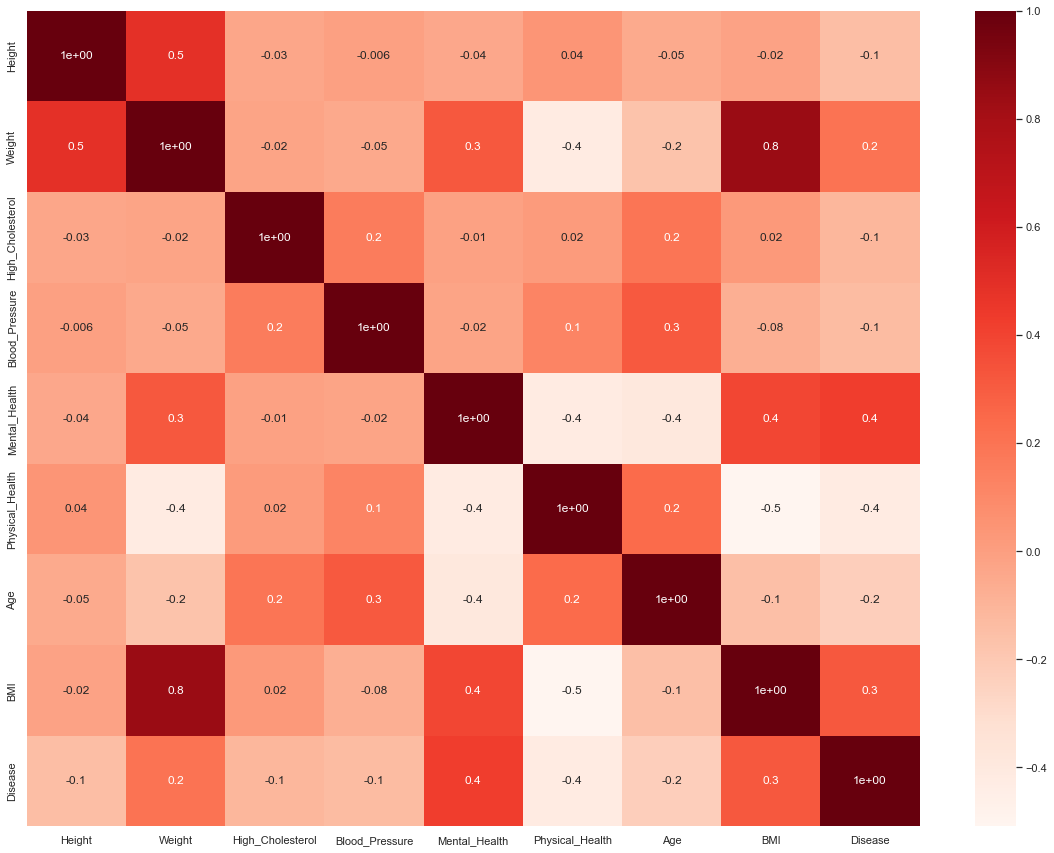

In [120]:
def cor_heatmap(cor,name):
    plt.figure(figsize=(20,15))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.savefig(name+'_cor_spearman_heatmap.png', dpi=200)
    plt.show()

# Baseline dataset (X_train + Y_train)
all_train1 = X_train_norm[metric].join(y_train)
all_train1.head()

cor_spearman = all_train1.corr(method ='spearman')
cor_heatmap(cor_spearman,'baseline')

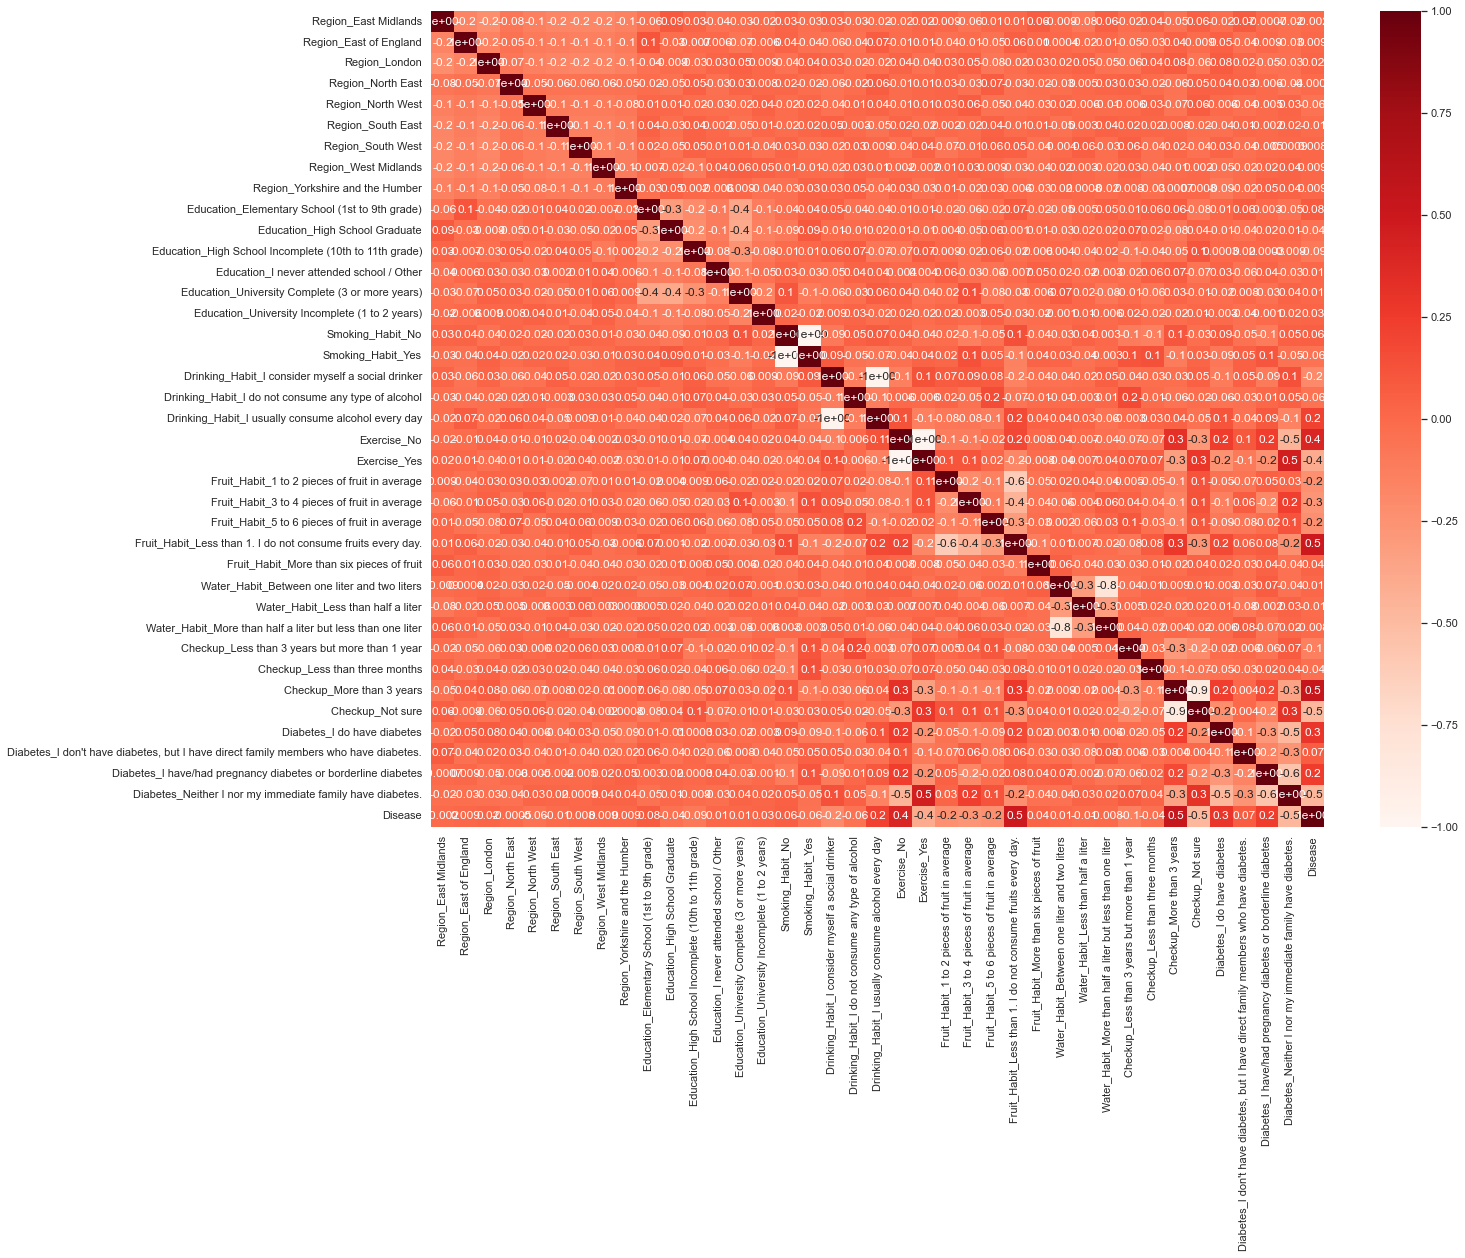

In [121]:
# Baseline dataset (X_train + Y_train)
all_train1 = X_train_norm[ohc_train_non_metric.columns].join(y_train)
all_train1.head()

cor_spearman = all_train1.corr(method ='spearman')
cor_heatmap(cor_spearman,'baseline')

## Spearman Correlation


 Selected Features: Age, BMI, Mental_Health, Physical_Health


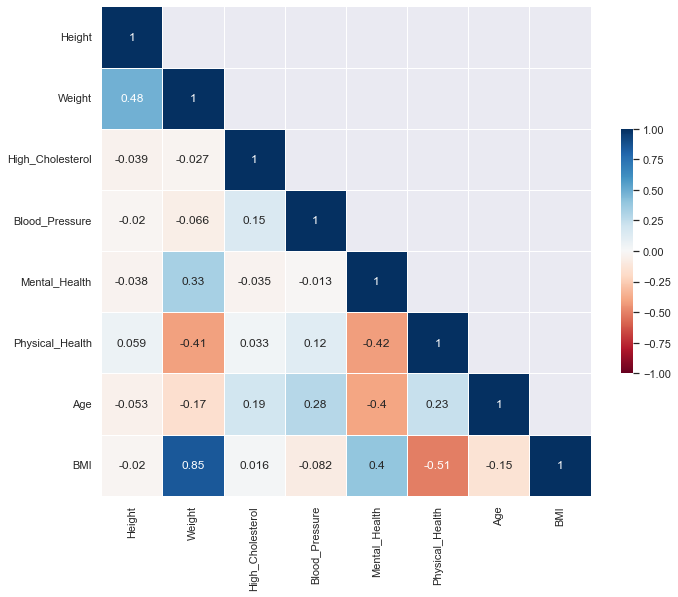

In [42]:
# Compute the correlation matrix - Spearman
corr = X_train_norm[metric].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
mask[np.diag_indices_from(mask)] = False
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = 'RdBu', vmax = 1, vmin=-1, center = 0,
            square = True, annot = True, linewidths = .5, cbar_kws = {"shrink": .5})
print("\n", "Selected Features: Age, BMI, Mental_Health, Physical_Health")

In [43]:
#According to Spearman's correlation we should remove 'Weight'

## 2Chi-Square

In [44]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [45]:
for var in train_full[non_metric_test]:
    TestIndependence(train_full[non_metric_test][var],y_train, var)

Region is NOT an important predictor. (Discard Region from model)
Education is NOT an important predictor. (Discard Education from model)
Smoking_Habit is NOT an important predictor. (Discard Smoking_Habit from model)
Drinking_Habit is IMPORTANT for Prediction
Exercise is IMPORTANT for Prediction
Fruit_Habit is IMPORTANT for Prediction
Water_Habit is NOT an important predictor. (Discard Water_Habit from model)
Checkup is IMPORTANT for Prediction
Diabetes is IMPORTANT for Prediction


In [46]:
columns_remove_chi_square_spearman = train_full.columns[    
    train_full.columns.str.startswith('Region') |
    train_full.columns.str.startswith('Education') | 
    train_full.columns.str.startswith('Smoking_Habit') |
    train_full.columns.str.startswith('Water_Habit') |
    train_full.columns.str.startswith('Weight')]

## L1 Regularization

In [47]:
# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", solver='liblinear', random_state=7).fit(X_train_norm, y_train)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X_train_norm)
X_new

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


array([[0.        , 0.        , 1.        , ..., 0.0952381 , 0.58333333,
        0.83028919],
       [0.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.94520548],
       [0.        , 0.        , 0.        , ..., 0.        , 0.39583333,
        0.67960426],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.27083333,
        0.5913242 ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.375     ,
        0.804414  ],
       [0.        , 0.        , 1.        , ..., 0.57142857, 0.29166667,
        0.48782344]])

In [48]:
# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X_train_norm.index,
                                 columns=X_train_norm.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns_l1 = selected_features.columns[selected_features.var() != 0]

In [49]:
selected_columns_l1.to_list()

['Region_East Midlands',
 'Region_East of England',
 'Region_London',
 'Region_North East',
 'Region_North West',
 'Region_South East',
 'Region_West Midlands',
 'Region_Yorkshire and the Humber',
 'Education_Elementary School (1st to 9th grade)',
 'Education_High School Graduate',
 'Education_High School Incomplete (10th to 11th grade)',
 'Education_I never attended school / Other',
 'Education_University Incomplete (1 to 2 years)',
 'Smoking_Habit_No',
 'Drinking_Habit_I consider myself a social drinker',
 'Exercise_Yes',
 'Fruit_Habit_1 to 2 pieces of fruit in average',
 'Fruit_Habit_3 to 4 pieces of fruit in average',
 'Fruit_Habit_Less than 1. I do not consume fruits every day.',
 'Fruit_Habit_More than six pieces of fruit',
 'Checkup_Less than three months',
 'Checkup_More than 3 years',
 'Checkup_Not sure',
 'Diabetes_I do have diabetes',
 'Diabetes_I have/had pregnancy diabetes or borderline diabetes',
 'Diabetes_Neither I nor my immediate family have diabetes.',
 'Height',
 'H

## RFE for Random Forest

In [50]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train_norm[metric_test], y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train_norm[metric_test].columns[rfecv.support_])

Optimal number of features : 6
Best features : Index(['High_Cholesterol', 'Blood_Pressure', 'Mental_Health',
       'Physical_Health', 'Age', 'BMI'],
      dtype='object')


In [51]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train_norm, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train_norm.columns[rfecv.support_])

Optimal number of features : 10
Best features : Index(['Fruit_Habit_Less than 1. I do not consume fruits every day.',
       'Checkup_More than 3 years', 'Checkup_Not sure',
       'Diabetes_Neither I nor my immediate family have diabetes.',
       'High_Cholesterol', 'Blood_Pressure', 'Mental_Health',
       'Physical_Health', 'Age', 'BMI'],
      dtype='object')


In [52]:
rfe_rf_variables = X_train_norm.columns[rfecv.support_].to_list()

## RFE for Gradient Boosting

In [53]:
def run_rfe(estimator):
    selector = RFECV(estimator, step=1, cv = 10)
    selector = selector.fit(X_train_norm, y_train)
    return selector.support_, selector.ranking_


In [54]:
model_estimator_gb = GradientBoostingClassifier(random_state = 5)
rfe_gb = run_rfe(model_estimator_gb)
selected_rfe_gb = pd.Series(rfe_gb[0], index = X_train_norm.columns)
rfe_gb_variables = list(selected_rfe_gb[selected_rfe_gb.values == True].index)
print(rfe_gb_variables)


['Fruit_Habit_Less than 1. I do not consume fruits every day.', 'Checkup_More than 3 years', 'Diabetes_Neither I nor my immediate family have diabetes.', 'High_Cholesterol', 'Physical_Health', 'Age']


## ANOVA

In [55]:
# Create an SelectKBest object to select features with best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif)
# Apply the SelectKBest object to the features and target
X_kbest = fvalue_selector.fit_transform(X_train_norm, y_train)
# Show results
print('Original number of features:', X_train_norm.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 46
Reduced number of features: 10


In [56]:
# Get columns to keep and create new dataframe with those only
cols = fvalue_selector.get_support(indices=True)
features_anova = X_train_norm.iloc[:,cols]
features_anova.columns

Index(['Exercise_No', 'Exercise_Yes',
       'Fruit_Habit_3 to 4 pieces of fruit in average',
       'Fruit_Habit_Less than 1. I do not consume fruits every day.',
       'Checkup_More than 3 years', 'Checkup_Not sure',
       'Diabetes_Neither I nor my immediate family have diabetes.',
       'Mental_Health', 'Physical_Health', 'BMI'],
      dtype='object')

## Lasso

In [57]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(6,8))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [58]:
reg = LassoCV()
reg.fit(X_train_norm[metric_test], y_train)
coef = pd.Series(reg.coef_, index = X_train_norm[metric_test].columns)
print(coef.sort_values())
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Physical_Health    -0.593399
Blood_Pressure     -0.282526
Height             -0.268504
High_Cholesterol   -0.221376
Weight              0.000000
Age                -0.000000
BMI                 0.071311
Mental_Health       0.773235
dtype: float64
Lasso picked 6 variables and eliminated the other 2 variables


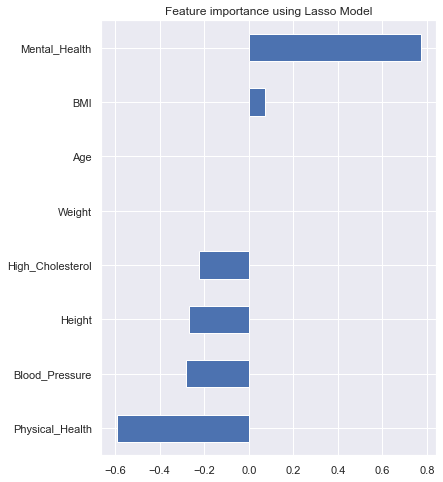

In [59]:
plot_importance(coef,'Lasso')

In [60]:
reg = LassoCV()
reg.fit(X_train_norm, y_train)
coef = pd.Series(reg.coef_, index = X_train_norm.columns)
print(coef.sort_values())
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Physical_Health                                                                       -2.925727e-01
Blood_Pressure                                                                        -1.920789e-01
Diabetes_Neither I nor my immediate family have diabetes.                             -1.658633e-01
Checkup_Less than three months                                                        -1.127982e-01
High_Cholesterol                                                                      -8.552223e-02
Drinking_Habit_I consider myself a social drinker                                     -8.198268e-02
Height                                                                                -8.119028e-02
Education_I never attended school / Other                                             -5.883000e-02
Smoking_Habit_No                                                                      -4.630614e-02
Region_East of England                                                                -4.332482e-02


In [61]:
lasso_variables = list(abs(coef)[abs(coef) >= 0.000001].index)
print(lasso_variables)


['Region_East Midlands', 'Region_East of England', 'Region_London', 'Region_North East', 'Region_North West', 'Region_South East', 'Region_West Midlands', 'Region_Yorkshire and the Humber', 'Education_Elementary School (1st to 9th grade)', 'Education_High School Graduate', 'Education_High School Incomplete (10th to 11th grade)', 'Education_I never attended school / Other', 'Education_University Complete (3 or more years)', 'Education_University Incomplete (1 to 2 years)', 'Smoking_Habit_No', 'Drinking_Habit_I consider myself a social drinker', 'Exercise_No', 'Fruit_Habit_1 to 2 pieces of fruit in average', 'Fruit_Habit_3 to 4 pieces of fruit in average', 'Fruit_Habit_Less than 1. I do not consume fruits every day.', 'Fruit_Habit_More than six pieces of fruit', 'Water_Habit_Between one liter and two liters', 'Water_Habit_Less than half a liter', 'Checkup_Less than 3 years but more than 1 year', 'Checkup_Less than three months', 'Checkup_More than 3 years', 'Checkup_Not sure', 'Diabetes_

In [62]:
lasso_variables

['Region_East Midlands',
 'Region_East of England',
 'Region_London',
 'Region_North East',
 'Region_North West',
 'Region_South East',
 'Region_West Midlands',
 'Region_Yorkshire and the Humber',
 'Education_Elementary School (1st to 9th grade)',
 'Education_High School Graduate',
 'Education_High School Incomplete (10th to 11th grade)',
 'Education_I never attended school / Other',
 'Education_University Complete (3 or more years)',
 'Education_University Incomplete (1 to 2 years)',
 'Smoking_Habit_No',
 'Drinking_Habit_I consider myself a social drinker',
 'Exercise_No',
 'Fruit_Habit_1 to 2 pieces of fruit in average',
 'Fruit_Habit_3 to 4 pieces of fruit in average',
 'Fruit_Habit_Less than 1. I do not consume fruits every day.',
 'Fruit_Habit_More than six pieces of fruit',
 'Water_Habit_Between one liter and two liters',
 'Water_Habit_Less than half a liter',
 'Checkup_Less than 3 years but more than 1 year',
 'Checkup_Less than three months',
 'Checkup_More than 3 years',
 'Che

## Decision Tree

In [63]:
gini_importance = DecisionTreeClassifier().fit(X_train_norm, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train_norm, y_train).feature_importances_

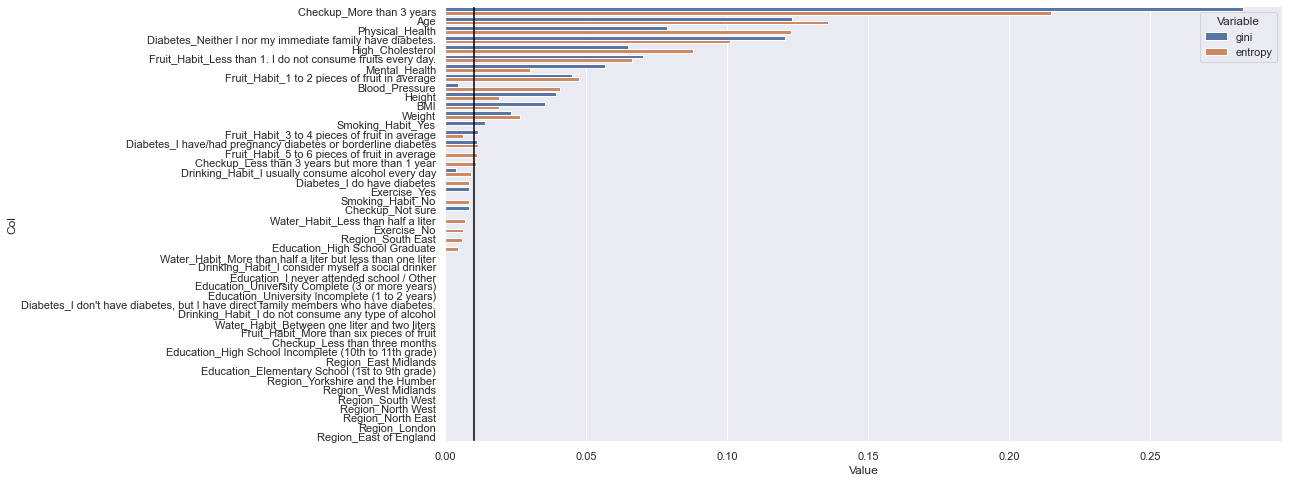

In [64]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_train_norm.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

plt.axvline(x = 0.01, ymin = 0, ymax = 10, color = "black")
plt.show()


In [65]:
tidy.sort_values(['Value'], ascending = False, inplace = True)
columns_gini = tidy[(tidy['Value'] > 0.008) & (tidy['Variable'] == 'gini')].Col.values
columns_entropy = tidy[(tidy['Value'] > 0.01 ) & (tidy['Variable'] == 'entropy')].Col.values
dt_variables = list(set(list(columns_entropy) + list(columns_gini)))
print(dt_variables)

['Diabetes_Neither I nor my immediate family have diabetes.', 'Fruit_Habit_5 to 6 pieces of fruit in average', 'Exercise_Yes', 'Checkup_More than 3 years', 'Checkup_Less than 3 years but more than 1 year', 'Checkup_Not sure', 'Mental_Health', 'Fruit_Habit_1 to 2 pieces of fruit in average', 'Blood_Pressure', 'BMI', 'Age', 'Diabetes_I have/had pregnancy diabetes or borderline diabetes', 'High_Cholesterol', 'Height', 'Weight', 'Smoking_Habit_Yes', 'Physical_Health', 'Fruit_Habit_Less than 1. I do not consume fruits every day.', 'Fruit_Habit_3 to 4 pieces of fruit in average']


## Ridge Regression

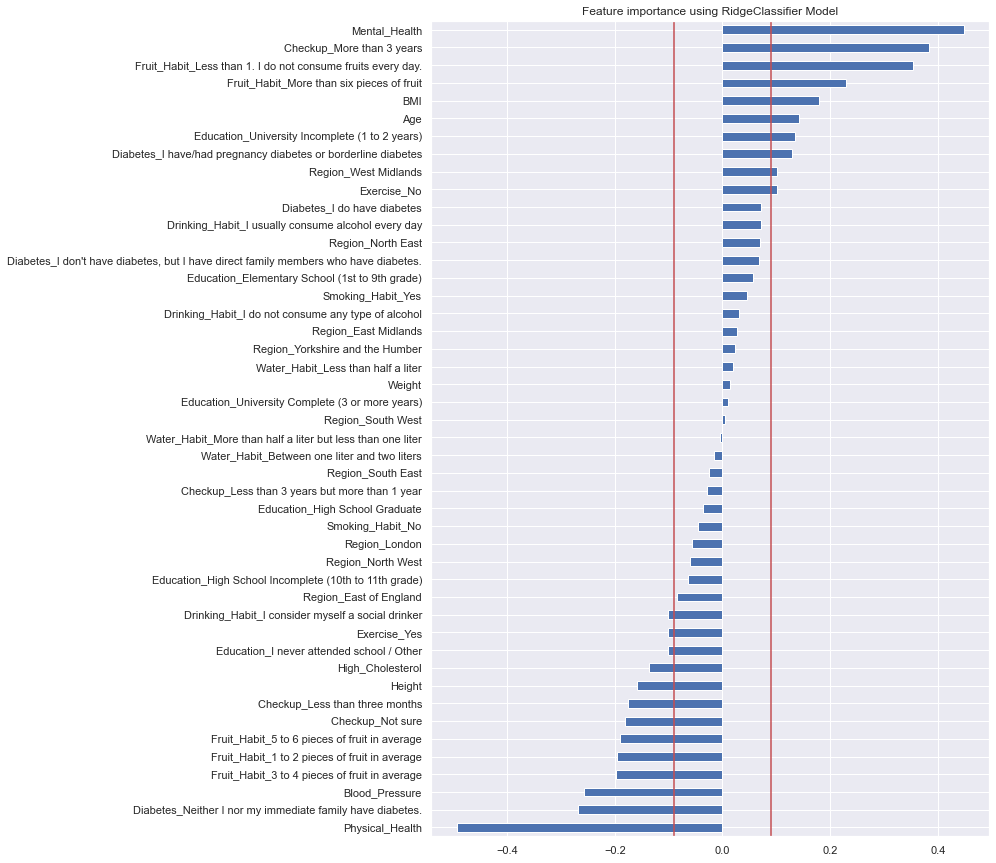

In [66]:
ridge = RidgeClassifierCV().fit(X = X_train_norm,y = y_train)
coef_ridge = pd.Series(ridge.coef_[0], index = X_train_norm.columns)
ridge_predictions = ridge.predict(X_train_norm)

def plot_importance(coef,name, threshold):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(10,15))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.axvline(x = threshold, ymin = 0, ymax = 10, color = "r")
    plt.axvline(x = -threshold, ymin = 0, ymax = 10, color = "r")
    plt.show()
plot_importance(coef_ridge,'RidgeClassifier', 0.09)

In [67]:
ridge_variables = list(abs(coef_ridge)[abs(coef_ridge) >= 0.1].index)
print(ridge_variables)

['Region_West Midlands', 'Education_I never attended school / Other', 'Education_University Incomplete (1 to 2 years)', 'Drinking_Habit_I consider myself a social drinker', 'Exercise_No', 'Exercise_Yes', 'Fruit_Habit_1 to 2 pieces of fruit in average', 'Fruit_Habit_3 to 4 pieces of fruit in average', 'Fruit_Habit_5 to 6 pieces of fruit in average', 'Fruit_Habit_Less than 1. I do not consume fruits every day.', 'Fruit_Habit_More than six pieces of fruit', 'Checkup_Less than three months', 'Checkup_More than 3 years', 'Checkup_Not sure', 'Diabetes_I have/had pregnancy diabetes or borderline diabetes', 'Diabetes_Neither I nor my immediate family have diabetes.', 'Height', 'High_Cholesterol', 'Blood_Pressure', 'Mental_Health', 'Physical_Health', 'Age', 'BMI']


<hr>
<a class="anchor" id="11">
    
# 11. Models
    
</a>

In [68]:
#Chi-square and Spearman
chi_spearman_variables = train_full.drop(columns = columns_remove_chi_square_spearman).columns
#L1_Regularization
l1_variables = selected_columns_l1
#RFE
rfe_variables = set(rfe_gb_variables) | set(rfe_rf_variables)

#Lasso
lasso_variables

#Decision Tree
dt_variables

#Ridge Regression 
ridge_variables

#Anova
anova_variables = features_anova.columns

In [69]:
X_train = X_train_norm.copy()
X_test = X_test_norm.copy() 
y_train = y_train.copy()

In [70]:
columns_remove_chi_square = X_train.columns[    #according to qui-square
    X_train.columns.str.startswith('Region') |
    X_train.columns.str.startswith('Smoking_Habit') |
    X_train.columns.str.startswith('Water_Habit')
]

X_train_chi_spearman = X_train.drop(columns = columns_remove_chi_square)

X_train_chi_spearman = X_train.drop(columns='Weight') #according to Spearman's correlation


Models to test:

- Random Forest
- Logistic Regression
- Decision Trees
- Regression Trees
- Random Forest
- KNN
- Ridge Classifier
- Support Vector Machine
- Neural Networks
- Ada Boost
- Gradient Boosting
- XGBoost

In [860]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [419]:
kfolds = KFold(n_splits = 10)

In [420]:
#def avg_score(method,X,y,model_,base_estimator=ExtraTreesClassifier(),n_neighbors=None, random_state = 43):
#    score_train = []
#    score_val = []
#
#    for train_index, val_index in method.split(X,y):
#        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#
#        try:
#            model = model_(random_state = 5).fit(X_train,y_train)
#
#        except:
#            model = model_().fit(X_train,y_train)
#
#
#        y_pred_train = model.predict(X_train)
#        y_pred_val = model.predict(X_val)
#        value_train = f1_score(y_train,y_pred_train, average = 'micro')
#        value_val = f1_score(y_val,y_pred_val, average = 'micro')
#       score_train.append(value_train)
#       score_val.append(value_val)
#
#    print('Train:', np.mean(score_train))
#    print('Val:', np.mean(score_val))
#
#
#    return np.mean(score_val)

def avg_score(method,X,y,model_,base_estimator=ExtraTreesClassifier(),n_neighbors=None,random_state=None, learning_rate=None):
    score_train = []
    score_val = []

    for train_index, val_index in method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if random_state:
            model = model_(random_state = random_state).fit(X_train,y_train)

        else:
            model = model_().fit(X_train,y_train)


        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        value_train = f1_score(y_train,y_pred_train, average = 'micro')
        value_val = f1_score(y_val,y_pred_val, average = 'micro')
        score_train.append(value_train)
        score_val.append(value_val)

    print('Train:', np.mean(score_train))
    print('Val:', np.mean(score_val))


    return np.mean(score_val)

## Logistic Regression

In [421]:
print('F1 Scores for Different Feature Selection Models')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,LogisticRegression)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,LogisticRegression)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,LogisticRegression) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,LogisticRegression)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,LogisticRegression)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,LogisticRegression)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,LogisticRegression)


F1 Scores for Different Feature Selection Models
_____________________________________________________
Chi Square and Spearman
Train: 0.8649087282398453
Val: 0.8288542680947744
_____________________________________________________
L1 Regularization
Train: 0.8627806656995485
Val: 0.8314345991561181
_____________________________________________________
Decision Trees
Train: 0.8553997421018698
Val: 0.8416910094125283
_____________________________________________________
Anova
Train: 0.8470269181173438
Val: 0.8391106783511846
_____________________________________________________
Ridge Regression
Train: 0.8607936411992263
Val: 0.8518987341772153
_____________________________________________________
Lasso
Train: 0.8637741779497098
Val: 0.8314183706588769
_____________________________________________________
RFE
Train: 0.853839055448098
Val: 0.8468192145407336


0.8468192145407336

## Support Vector Machine (SVM)

In [422]:
# https://www.kaggle.com/code/adepvenugopal/support-vector-machines-predicting-heart-disease

In [423]:
#Create a svm Classifier
svm_model = svm.SVC

In [424]:
print('F1 Scores for Different Feature Selection Models')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,svm_model)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,svm_model)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,svm_model) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,svm_model)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,svm_model)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,svm_model)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,svm_model)


F1 Scores for Different Feature Selection Models
_____________________________________________________
Chi Square and Spearman
Train: 0.9167033365570599
Val: 0.8570593962999027
_____________________________________________________
L1 Regularization
Train: 0.9142901756931014
Val: 0.8531807854592666
_____________________________________________________
Decision Trees
Train: 0.8901674323017408
Val: 0.8634047387211945
_____________________________________________________
Anova
Train: 0.8661837121212121
Val: 0.8544466082440767
_____________________________________________________
Ridge Regression
Train: 0.9063457043842682
Val: 0.8659850697825382
_____________________________________________________
Lasso
Train: 0.9121621131528045
Val: 0.8582927620902305
_____________________________________________________
RFE
Train: 0.8786724290780142
Val: 0.8647030185004869


0.8647030185004869

## Decision Tree


In [425]:
dt_model = DecisionTreeClassifier

In [426]:
print('F1 Scores for Different Feature Selection Models - Decision Tree')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,dt_model,random_state = 1)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,dt_model,random_state = 1)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,dt_model,random_state = 1) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,dt_model,random_state = 1)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,dt_model,random_state = 1)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,dt_model,random_state = 1)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,dt_model,random_state = 1)


F1 Scores for Different Feature Selection Models - Decision Tree
_____________________________________________________
Chi Square and Spearman
Train: 1.0
Val: 0.9425024342745862
_____________________________________________________
L1 Regularization
Train: 1.0
Val: 0.9463323596234989
_____________________________________________________
Decision Trees
Train: 1.0
Val: 0.9591366439467706
_____________________________________________________
Anova
Train: 1.0
Val: 0.9017364492048037
_____________________________________________________
Ridge Regression
Train: 1.0
Val: 0.9437520285621552
_____________________________________________________
Lasso
Train: 1.0
Val: 0.9386725089256736
_____________________________________________________
RFE
Train: 1.0
Val: 0.9539272963323595


0.9539272963323595

## Random Forest

In [427]:
#X_train = X_train_norm.copy()
#X_test = X_test_norm.copy() 

In [428]:
#columns_remove_chi_square = X_train.columns[    #according to qui-square
#    X_train.columns.str.startswith('Region') |
#    X_train.columns.str.startswith('Smoking_Habit') |
#    X_train.columns.str.startswith('Water_Habit')
#]
#
#X_train_chi_spearman = X_train.drop(columns = columns_remove_chi_square)
#
#X_train_chi_spearman = X_train.drop(columns='Weight') #according to Spearman's correlation

In [429]:
rf_model = RandomForestClassifier

In [430]:
print('F1 Scores for Different Feature Selection Models - Random Forest')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,rf_model, random_state=1)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,rf_model, random_state=1)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,rf_model, random_state=1) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,rf_model, random_state=1)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,rf_model, random_state=1)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,rf_model, random_state=1)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,rf_model, random_state=1)


F1 Scores for Different Feature Selection Models - Random Forest
_____________________________________________________
Chi Square and Spearman
Train: 1.0
Val: 0.9667964946445959
_____________________________________________________
L1 Regularization
Train: 1.0
Val: 0.9604186952288218
_____________________________________________________
Decision Trees
Train: 1.0
Val: 0.9642323920804934
_____________________________________________________
Anova
Train: 1.0
Val: 0.9310775722168128
_____________________________________________________
Ridge Regression
Train: 1.0
Val: 0.9731580655631289
_____________________________________________________
Lasso
Train: 1.0
Val: 0.95407335280753
_____________________________________________________
RFE
Train: 1.0
Val: 0.9783511846802986


0.9783511846802986

## KNN

In [434]:
knn_model = KNeighborsClassifier

In [435]:
print('F1 Scores for Different Feature Selection Models - Random Forest')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,knn_model,n_neighbors=5)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,knn_model,n_neighbors=5)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,knn_model,n_neighbors=5) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,knn_model,n_neighbors=5)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,knn_model,n_neighbors=5)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,knn_model,n_neighbors=5)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,knn_model,n_neighbors=5)


F1 Scores for Different Feature Selection Models - Random Forest
_____________________________________________________
Chi Square and Spearman
Train: 0.9184050612508059
Val: 0.8557773450178514
_____________________________________________________
L1 Regularization
Train: 0.909324830754352
Val: 0.8532294709509898
_____________________________________________________
Decision Trees
Train: 0.9395478723404256
Val: 0.859623498864005
_____________________________________________________
Anova
Train: 0.9169860170857511
Val: 0.8519149626744562
_____________________________________________________
Ridge Regression
Train: 0.9297570116054159
Val: 0.8775073028237586
_____________________________________________________
Lasso
Train: 0.8921544568020632
Val: 0.8429730606945796
_____________________________________________________
RFE
Train: 0.936284050612508
Val: 0.8353456669912365


0.8353456669912365

In [436]:
knn_model = KNeighborsClassifier

In [437]:
print('F1 Scores for Different Feature Selection Models - Random Forest')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,knn_model,n_neighbors=1)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,knn_model,n_neighbors=1)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,knn_model,n_neighbors=1) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,knn_model,n_neighbors=1)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,knn_model,n_neighbors=1)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,knn_model,n_neighbors=1)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,knn_model,n_neighbors=1)


F1 Scores for Different Feature Selection Models - Random Forest
_____________________________________________________
Chi Square and Spearman
Train: 0.9184050612508059
Val: 0.8557773450178514
_____________________________________________________
L1 Regularization
Train: 0.909324830754352
Val: 0.8532294709509898
_____________________________________________________
Decision Trees
Train: 0.9395478723404256
Val: 0.859623498864005
_____________________________________________________
Anova
Train: 0.9169860170857511
Val: 0.8519149626744562
_____________________________________________________
Ridge Regression
Train: 0.9297570116054159
Val: 0.8775073028237586
_____________________________________________________
Lasso
Train: 0.8921544568020632
Val: 0.8429730606945796
_____________________________________________________
RFE
Train: 0.936284050612508
Val: 0.8353456669912365


0.8353456669912365

## Neural Networks

In [439]:
nn_model = MLPClassifier

In [440]:
print('F1 Scores for Different Feature Selection Models - Neural Networks')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,nn_model)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,nn_model)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,nn_model) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,nn_model)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,nn_model)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,nn_model)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,nn_model)


F1 Scores for Different Feature Selection Models - Neural Networks
_____________________________________________________
Chi Square and Spearman
Train: 0.969064111863314
Val: 0.8621389159363844
_____________________________________________________
L1 Regularization
Train: 0.9537385154738878
Val: 0.8596559558584875
_____________________________________________________
Decision Trees
Train: 0.906485533526757
Val: 0.8787082116196041
_____________________________________________________
Anova
Train: 0.8615004432624114
Val: 0.8442064264849074
_____________________________________________________
Ridge Regression
Train: 0.9281961234687298
Val: 0.8825543654657579
_____________________________________________________
Lasso
Train: 0.9486323339780787
Val: 0.867218435572866
_____________________________________________________
RFE
Train: 0.8708657720825274
Val: 0.8557773450178514


0.8557773450178514

## Ada Boost Classifier

In [442]:
abc_model = AdaBoostClassifier

In [443]:
print('F1 Scores for Different Feature Selection Models - Random Forest')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,abc_model, random_state = 33)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,abc_model, random_state = 33)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,abc_model, random_state = 33) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,abc_model, random_state = 33)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,abc_model, random_state = 33)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,abc_model, random_state = 33)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,abc_model, random_state = 33)

F1 Scores for Different Feature Selection Models - Random Forest
_____________________________________________________
Chi Square and Spearman
Train: 0.9218115328820117
Val: 0.8672022070756247
_____________________________________________________
L1 Regularization
Train: 0.9189744519664733
Val: 0.8684518013631937
_____________________________________________________
Decision Trees
Train: 0.9154257333978079
Val: 0.8659363842908148
_____________________________________________________
Anova
Train: 0.8798061734364927
Val: 0.8518338201882505
_____________________________________________________
Ridge Regression
Train: 0.9176970502901354
Val: 0.8658876987990911
_____________________________________________________
Lasso
Train: 0.9195424323017409
Val: 0.864621876014281
_____________________________________________________
RFE
Train: 0.9104579706640876
Val: 0.8722654982148654


0.8722654982148654

## XGBoost Classifier

In [445]:
xgb_model = XGBClassifier

In [446]:
print('F1 Scores for Different Feature Selection Models - Random Forest')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,xgb_model)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,xgb_model)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,xgb_model) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,xgb_model)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,xgb_model)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,xgb_model)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,xgb_model)

F1 Scores for Different Feature Selection Models - Random Forest
_____________________________________________________
Chi Square and Spearman
Train: 1.0
Val: 0.9617169750081143
_____________________________________________________
L1 Regularization
Train: 1.0
Val: 0.974537487828627
_____________________________________________________
Decision Trees
Train: 1.0
Val: 0.9681272314183706
_____________________________________________________
Anova
Train: 1.0
Val: 0.9132262252515417
_____________________________________________________
Ridge Regression
Train: 1.0
Val: 0.9745050308341447
_____________________________________________________
Lasso
Train: 1.0
Val: 0.9655631288542681
_____________________________________________________
RFE
Train: 1.0
Val: 0.9719571567672833


0.9719571567672833

## Gradient Boosting Classifier

In [448]:
gbc_model = GradientBoostingClassifier

In [449]:
print('F1 Scores for Different Feature Selection Models - Gradient Boosting')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,gbc_model, random_state=1)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,gbc_model, random_state=1)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,gbc_model, random_state=1) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,gbc_model, random_state=1)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,gbc_model, random_state=1)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,gbc_model, random_state=1)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,gbc_model, random_state=1)

F1 Scores for Different Feature Selection Models - Gradient Boosting
_____________________________________________________
Chi Square and Spearman
Train: 0.9887894906511928
Val: 0.9361733203505356
_____________________________________________________
L1 Regularization
Train: 0.986236097678917
Val: 0.9335929892891919
_____________________________________________________
Decision Trees
Train: 0.9856691247582205
Val: 0.9336254462836742
_____________________________________________________
Anova
Train: 0.9442311411992265
Val: 0.8837715027588446
_____________________________________________________
Ridge Regression
Train: 0.9855262733720179
Val: 0.9361408633560533
_____________________________________________________
Lasso
Train: 0.9870865570599614
Val: 0.9361895488477767
_____________________________________________________
RFE
Train: 0.9845331640876853
Val: 0.9335929892891919


0.9335929892891919

## Ridge Classifier

In [451]:
rc_model = RidgeClassifier

In [452]:
print('F1 Scores for Different Feature Selection Models - Random Forest')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,rc_model,random_state=1)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,rc_model,random_state=1)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,rc_model,random_state=1) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,rc_model,random_state=1)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,rc_model,random_state=1)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,rc_model,random_state=1)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,rc_model,random_state=1)

F1 Scores for Different Feature Selection Models - Random Forest
_____________________________________________________
Chi Square and Spearman
Train: 0.8678878546099291
Val: 0.8442388834793897
_____________________________________________________
L1 Regularization
Train: 0.8680303030303032
Val: 0.8429730606945796
_____________________________________________________
Decision Trees
Train: 0.861360815602837
Val: 0.8519311911716974
_____________________________________________________
Anova
Train: 0.847309800128949
Val: 0.8428919182083738
_____________________________________________________
Ridge Regression
Train: 0.8636307221147647
Val: 0.840408958130477
_____________________________________________________
Lasso
Train: 0.8681721470019342
Val: 0.8480850373255435
_____________________________________________________
RFE
Train: 0.8532702691811735
Val: 0.8442551119766311


0.8442551119766311

## Extra Trees Classifier

In [454]:
etc_model = ExtraTreesClassifier

In [455]:
print('F1 Scores for Different Feature Selection Models - Random Forest')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,etc_model,random_state=1)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,etc_model,random_state=1)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,etc_model,random_state=1) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,etc_model,random_state=1)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,etc_model,random_state=1)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,etc_model,random_state=1)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,etc_model,random_state=1)

F1 Scores for Different Feature Selection Models - Random Forest
_____________________________________________________
Chi Square and Spearman
Train: 1.0
Val: 0.9451314508276534
_____________________________________________________
L1 Regularization
Train: 1.0
Val: 0.9578870496592016
_____________________________________________________
Decision Trees
Train: 1.0
Val: 0.9859461213891594
_____________________________________________________
Anova
Train: 1.0
Val: 0.9502271989613762
_____________________________________________________
Ridge Regression
Train: 1.0
Val: 0.9859623498864005
_____________________________________________________
Lasso
Train: 1.0
Val: 0.9451314508276534
_____________________________________________________
RFE
Train: 1.0
Val: 0.9872768581629341


0.9872768581629341

## Bagging Classifier

In [457]:
bc_model = BaggingClassifier

In [458]:
print('F1 Scores for Different Feature Selection Models - Random Forest')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,bc_model,base_estimator = DecisionTreeClassifier(), random_state = 43)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train_chi_spearman,y_train,bc_model,base_estimator = DecisionTreeClassifier(), random_state = 43)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train_chi_spearman,y_train,bc_model,base_estimator = DecisionTreeClassifier(), random_state = 43) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train_chi_spearman,y_train,bc_model,base_estimator = DecisionTreeClassifier(), random_state = 43)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train_chi_spearman,y_train,bc_model,base_estimator = DecisionTreeClassifier(), random_state = 43)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train_chi_spearman,y_train,bc_model,base_estimator = DecisionTreeClassifier(), random_state = 43)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train_chi_spearman,y_train,bc_model,base_estimator = DecisionTreeClassifier(), random_state = 43)

F1 Scores for Different Feature Selection Models - Random Forest
_____________________________________________________
Chi Square and Spearman
Train: 0.9987225983236622
Val: 0.9477117818889971
_____________________________________________________
L1 Regularization
Train: 0.9987225983236622
Val: 0.9477117818889971
_____________________________________________________
Decision Trees
Train: 0.9987225983236622
Val: 0.9477117818889971
_____________________________________________________
Anova
Train: 0.9987225983236622
Val: 0.9477117818889971
_____________________________________________________
Ridge Regression
Train: 0.9987225983236622
Val: 0.9477117818889971
_____________________________________________________
Lasso
Train: 0.9987225983236622
Val: 0.9477117818889971
_____________________________________________________
RFE
Train: 0.9987225983236622
Val: 0.9477117818889971


0.9477117818889971

In [459]:
bc_model = BaggingClassifier

In [460]:
print('F1 Scores for Different Feature Selection Models - Random Forest')
print('_____________________________________________________')
print('Chi Square and Spearman')
avg_score(kfolds,X_train_chi_spearman,y_train,bc_model,base_estimator = ExtraTreesClassifier(), random_state = 43)
print('_____________________________________________________')
print('L1 Regularization')
avg_score(kfolds,X_train[l1_variables],y_train,bc_model,base_estimator = ExtraTreesClassifier(), random_state = 43)
print('_____________________________________________________')
print('Decision Trees')
avg_score(kfolds,X_train[dt_variables],y_train,bc_model,base_estimator = ExtraTreesClassifier(), random_state = 43) 
print('_____________________________________________________')
print('Anova')
avg_score(kfolds,X_train[anova_variables],y_train,bc_model,base_estimator = ExtraTreesClassifier(), random_state = 43)
print('_____________________________________________________')
print('Ridge Regression')
avg_score(kfolds,X_train[ridge_variables],y_train,bc_model,base_estimator = ExtraTreesClassifier(), random_state = 43)
print('_____________________________________________________')
print('Lasso')
avg_score(kfolds,X_train[lasso_variables],y_train,bc_model,base_estimator = ExtraTreesClassifier(), random_state = 43)
print('_____________________________________________________')
print('RFE')
avg_score(kfolds,X_train[rfe_variables],y_train,bc_model,base_estimator = ExtraTreesClassifier(), random_state = 43)

F1 Scores for Different Feature Selection Models - Random Forest
_____________________________________________________
Chi Square and Spearman
Train: 0.9987225983236622
Val: 0.9477117818889971
_____________________________________________________
L1 Regularization
Train: 0.9981550209542231
Val: 0.9451801363193768
_____________________________________________________
Decision Trees
Train: 0.9978707285622178
Val: 0.9489613761765661
_____________________________________________________
Anova
Train: 0.996310646357189
Val: 0.9094125283998702
_____________________________________________________
Ridge Regression
Train: 0.9975874435847839
Val: 0.9489776046738072
_____________________________________________________
Lasso
Train: 0.9981546179883946
Val: 0.941333982473223
_____________________________________________________
RFE
Train: 0.9987221953578338
Val: 0.9489938331710484


0.9489938331710484

<hr>
<a class="anchor" id="7">
    
# 12. Train Test Split
    
</a>

In [94]:
non_metric = ["Region", "Education", "Smoking_Habit", "Drinking_Habit", "Exercise", "Fruit_Habit", "Water_Habit","Checkup","Diabetes","Disease"]
metric = train_full.columns.drop(non_metric).to_list()

non_metric_test = ["Region", "Education", "Smoking_Habit", "Drinking_Habit", "Exercise", "Fruit_Habit", "Water_Habit","Checkup","Diabetes"]
metric_test = test_full.columns.drop(non_metric_test).to_list()

In [95]:
train_non_metric = train_full[non_metric].copy()
train_metric = train_full[metric].copy()

validation_non_metric = train_full[non_metric].copy()
validation_metric = train_full[metric].copy()

test_non_metric = test_full[non_metric_test].copy()
test_metric = test_full[metric_test].copy()

In [96]:
X_test = test_full.copy()

In [97]:
# Splitting our training dataset into 'Train' and 'Validation'

# Defining X and y
y = train_full['Disease'].copy()
X = train_full.drop('Disease', axis = 1).copy()


#train test split
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                random_state = 1,
                                                test_size = 0.15)

In [98]:
# Encoding - non metric variables
# Train
scaler = OneHotEncoder()
OneHotEnc = scaler.fit(X_train[non_metric_test])
ohc_feat = OneHotEnc.transform(X_train[non_metric_test])
ohc_feat_names = OneHotEnc.get_feature_names_out()
ohc_train_non_metric = pd.DataFrame(OneHotEnc.transform(X_train[non_metric_test]).toarray(),columns=ohc_feat_names,index=X_train[non_metric_test].index)

In [99]:
# Validation
ohc_feat = OneHotEnc.transform(X_val[non_metric_test])
ohc_feat_names = OneHotEnc.get_feature_names_out()
ohc_val_non_metric = pd.DataFrame(OneHotEnc.transform(X_val[non_metric_test]).toarray(),columns=ohc_feat_names,index=X_val[non_metric_test].index)

In [100]:
# Test
ohc_feat = OneHotEnc.transform(X_test[non_metric_test])
ohc_feat_names = OneHotEnc.get_feature_names_out()
ohc_test_non_metric = pd.DataFrame(OneHotEnc.transform(X_test[non_metric_test]).toarray(),columns=ohc_feat_names,index=X_test[non_metric_test].index)

In [101]:
# Normalizing - metric variables
df_minmax_train = X_train[metric].copy()
df_minmax_val = X_val[metric].copy()
df_minmax_test = test_full[metric].copy()

In [102]:
scaler = MinMaxScaler().fit(df_minmax_train)

In [103]:
# Train
X_train_num_scaled = scaler.transform(df_minmax_train)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = df_minmax_train.columns).set_index(df_minmax_train.index)

In [104]:
# Train
min_max_X_train = pd.DataFrame(scaler.transform(df_minmax_train), columns=df_minmax_train.columns,index=X_train[metric_test].index)

In [105]:
# Test
min_max_X_test = pd.DataFrame(scaler.transform(df_minmax_test),columns=df_minmax_test.columns,index=df_minmax_test.index)

In [106]:
# Validation
min_max_X_val = pd.DataFrame(scaler.transform(df_minmax_val),columns=df_minmax_val.columns,index=df_minmax_val.index)

In [107]:
X_train_norm = pd.concat([ohc_train_non_metric, min_max_X_train], axis=1)
X_val_norm = pd.concat([ohc_val_non_metric, min_max_X_val], axis=1)
X_test_norm = pd.concat([ohc_test_non_metric, min_max_X_test], axis=1)

In [108]:
X_train = X_train_norm.copy()
X_val = X_val_norm.copy()
X_test = X_test_norm.copy()

<hr>
<a class="anchor" id="13">
    
# 13. Improving Results - Hyperparameters Tunning
    
</a>

## Decision Tree

In [478]:
# RFE (Feature Selection) - Decision Tree (Model)
dt_model = DecisionTreeClassifier(random_state = 1).fit(X_train[rfe_variables], y_train)
labels_train_dt =dt_model.predict(X_train[rfe_variables])
labels_val_dt = dt_model.predict(X_val[rfe_variables])
labels_test_dt = dt_model.predict(X_test[rfe_variables])

In [479]:
# Setting params
parameter_space = {
    'max_depth': [4,5,6,8,12,15,20,21],  
    'criterion': ['gini', 'entropy'],
    'splitter': ['random', 'best'],
    'max_features': [None, 0.5,'auto', 'log2',2, 4,6,8,10], #6,8,10,15,20,30,46, None
    'max_leaf_nodes': [None,4,8,12,15,16] #4,8,12,15, None
}

modelDT = DecisionTreeClassifier(random_state=1)
clf = GridSearchCV(modelDT, parameter_space, scoring = 'f1', return_train_score = True)
clf.fit(X_train[rfe_variables], y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 8, 12, 15, 20, 21],
                         'max_features': [None, 0.5, 'auto', 'log2', 2, 4, 6, 8,
                                          10],
                         'max_leaf_nodes': [None, 4, 8, 12, 15, 16],
                         'splitter': ['random', 'best']},
             return_train_score=True, scoring='f1')

In [480]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
# Associated to each model that I have just created
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
mean_trains = clf.cv_results_['mean_train_score']
params = clf.cv_results_['params']

results = pd.DataFrame(zip(means, stds, mean_trains, params), columns=['Mean Val','Std','Mean Train','Params'])
results.sort_values(by=['Mean Val'], inplace = True, ascending = False)
results

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'criterion': 'gini', 'max_depth': 15, 'max_features': 6, 'max_leaf_nodes': None, 'splitter': 'random'}
------------------------------------------------------------------------------------------------------------------------


,Mean Val,Std,Mean Train,Params
612,0.963178,0.017992,1.000000,"{'criterion': 'gini', 'max_depth': 15, 'max_fe..."
720,0.963178,0.017992,1.000000,"{'criterion': 'gini', 'max_depth': 20, 'max_fe..."
828,0.963178,0.017992,1.000000,"{'criterion': 'gini', 'max_depth': 21, 'max_fe..."
504,0.954359,0.021831,0.997512,"{'criterion': 'gini', 'max_depth': 12, 'max_fe..."
516,0.954263,0.005864,0.998942,"{'criterion': 'gini', 'max_depth': 12, 'max_fe..."
...,...,...,...,...
1723,NaN,NaN,NaN,"{'criterion': 'entropy', 'max_depth': 21, 'max..."
1724,NaN,NaN,NaN,"{'criterion': 'entropy', 'max_depth': 21, 'max..."
1725,NaN,NaN,NaN,"{'criterion': 'entropy', 'max_depth': 21, 'max..."
1726,NaN,NaN,NaN,"{'criterion': 'entropy', 'max_depth': 21, 'max..."


In [657]:
# Creating Decision Tree Model
DTModel = DecisionTreeClassifier(criterion = 'entropy', max_depth = 15, max_features = 6, max_leaf_nodes = None, splitter ='random',random_state = 1)
DTModel.fit(X_train[rfe_variables], y_train)
labels_train_dt =DTModel.predict(X_train[rfe_variables])
labels_val_dt = DTModel.predict(X_val[rfe_variables])

In [658]:
metrics(y_train = y_train, pred_train = labels_train_dt, y_val = y_val, pred_val = labels_val_dt)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       353

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665

[[312   0]
 [  0 353]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

In [659]:
#Predictions
y_pred_train_DT = DTModel.predict(X_train[rfe_variables])
y_pred_val_DT = DTModel.predict(X_val[rfe_variables])
y_pred_test_DT = DTModel.predict(X_test[rfe_variables])

#0.96774

In [660]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, y_pred_train_DT))
print('F1 Score to the Validation dataset:', f1_score(y_val, y_pred_val_DT))
print('Kaggle Score: 0.96774')


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 0.9902912621359222
Kaggle Score: 0.96774


In [ ]:
sub_7 = X_test_norm.copy()
sub_7['Disease'] = labels_test_dt
sub_7 = sub_7[['Disease']]
compression_opts = dict(method='zip',
                        archive_name='Group24_st2.csv')
sub_6.to_csv('testst2.zip',
          compression=compression_opts)

## Random Forest

In [485]:
parameter_space = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [.01, .001,.0015,0.002],
              'max_depth' : [7, 8, 9, 10],
              'criterion' :['gini', 'entropy'],
              'n_estimators': [100,200]
             }
modelRF = RandomForestClassifier(random_state=1)
clf = GridSearchCV(modelRF, parameter_space, scoring = 'f1', return_train_score = True)
clf.fit(X_train[rfe_variables], y_train)


GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'ccp_alpha': [0.01, 0.001, 0.0015, 0.002],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200]},
             return_train_score=True, scoring='f1')

In [486]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
# Associated to each model that I have just created
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
mean_trains = clf.cv_results_['mean_train_score']
params = clf.cv_results_['params']

results = pd.DataFrame(zip(means, stds, mean_trains, params), columns=['Mean Val','Std','Mean Train','Params'])
results.sort_values(by=['Mean Val'], inplace = True, ascending = False)
results

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
------------------------------------------------------------------------------------------------------------------------


,Mean Val,Std,Mean Train,Params
142,0.964856,0.017178,1.000000,"{'ccp_alpha': 0.0015, 'criterion': 'entropy', ..."
190,0.964856,0.017178,1.000000,"{'ccp_alpha': 0.002, 'criterion': 'entropy', '..."
188,0.964856,0.017178,1.000000,"{'ccp_alpha': 0.002, 'criterion': 'entropy', '..."
140,0.964856,0.017178,1.000000,"{'ccp_alpha': 0.0015, 'criterion': 'entropy', ..."
186,0.964856,0.017178,1.000000,"{'ccp_alpha': 0.002, 'criterion': 'entropy', '..."
...,...,...,...,...
20,0.885012,0.023265,0.914745,"{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_..."
22,0.885012,0.023265,0.914745,"{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_..."
6,0.884845,0.018203,0.914896,"{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_..."
8,0.884845,0.018203,0.914896,"{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_..."


In [627]:
# Creating Random Forest Model
RFModel = RandomForestClassifier(random_state = 1, criterion = 'entropy', max_depth = 15, max_features = 'auto', ccp_alpha = 0.001, n_estimators=200)
RFModel.fit(X_train[rfe_variables], y_train)
labels_train_rf =RFModel.predict(X_train[rfe_variables])
labels_val_rf = RFModel.predict(X_val[rfe_variables])

In [628]:
metrics(y_train = y_train, pred_train = labels_train_rf, y_val = y_val, pred_val = labels_val_rf)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       353

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665

[[312   0]
 [  0 353]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

In [629]:
#Predictions
y_pred_train_RF = RFModel.predict(X_train[rfe_variables])
y_pred_val_RF = RFModel.predict(X_val[rfe_variables])
y_pred_test_RF = RFModel.predict(X_test[rfe_variables])

In [630]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, y_pred_train_RF))
print('F1 Score to the Validation dataset:', f1_score(y_val, y_pred_val_RF))
print('Kaggle Score: 0.94623')


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 1.0
Kaggle Score: 0.94623


## KNN

In [491]:
# Using RFE feature selection because it was the one that gave the best performance

In [492]:
#https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning

In [493]:
grid_params = { 'n_neighbors' : [1,2,5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
              'leaf_size': [10,20,30,40,50],
               'n_jobs': [-1, None]
               
              }

model_knn = KNeighborsClassifier()
clf= GridSearchCV(model_knn,grid_params,scoring = 'f1', return_train_score = True)
clf.fit(X_train[rfe_variables],y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [10, 20, 30, 40, 50],
                         'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_jobs': [-1, None],
                         'n_neighbors': [1, 2, 5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [494]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
# Associated to each model that I have just created
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
mean_trains = clf.cv_results_['mean_train_score']
params = clf.cv_results_['params']

results = pd.DataFrame(zip(means, stds, mean_trains, params), columns=['Mean Val','Std','Mean Train','Params'])
results.sort_values(by=['Mean Val'], inplace = True, ascending = False)
results

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'leaf_size': 10, 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 1, 'weights': 'uniform'}
------------------------------------------------------------------------------------------------------------------------


,Mean Val,Std,Mean Train,Params
273,0.967455,0.016400,1.000000,"{'leaf_size': 30, 'metric': 'manhattan', 'n_jo..."
179,0.967455,0.016400,1.000000,"{'leaf_size': 20, 'metric': 'manhattan', 'n_jo..."
353,0.967455,0.016400,1.000000,"{'leaf_size': 40, 'metric': 'manhattan', 'n_jo..."
352,0.967455,0.016400,1.000000,"{'leaf_size': 40, 'metric': 'manhattan', 'n_jo..."
275,0.967455,0.016400,1.000000,"{'leaf_size': 30, 'metric': 'manhattan', 'n_jo..."
...,...,...,...,...
300,0.850757,0.024484,0.875163,"{'leaf_size': 40, 'metric': 'minkowski', 'n_jo..."
108,0.850757,0.024484,0.875163,"{'leaf_size': 20, 'metric': 'minkowski', 'n_jo..."
236,0.850757,0.024484,0.875163,"{'leaf_size': 30, 'metric': 'euclidean', 'n_jo..."
444,0.850757,0.024484,0.875163,"{'leaf_size': 50, 'metric': 'euclidean', 'n_jo..."


In [495]:
# Creating KNN Model
KNNModel = KNeighborsClassifier(leaf_size = 10, metric = 'manhattan', n_neighbors = 1, weights = 'uniform', n_jobs= -1)
KNNModel.fit(X_train[rfe_variables], y_train)
labels_train_knn =KNNModel.predict(X_train[rfe_variables])
labels_val_knn = KNNModel.predict(X_val[rfe_variables])
labels_test_knn = KNNModel.predict(X_test[rfe_variables])

In [496]:
metrics(y_train = y_train, pred_train = labels_train_knn, y_val = y_val, pred_val = labels_val_knn)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       353

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665

[[312   0]
 [  0 353]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

In [497]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, labels_train_knn))
print('F1 Score to the Validation dataset:', f1_score(y_val, labels_val_knn))
print('Kaggle Score: 0.97826 ')


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 1.0
Kaggle Score: 0.97826 


In [498]:
sub_7 = X_test_norm.copy()
sub_7['Disease'] = labels_test_knn
sub_7 = sub_7[['Disease']]
compression_opts = dict(method='zip',
                        archive_name='Group24_knn.csv')
sub_7.to_csv('testknn.zip',
          compression=compression_opts)

## XGBoost Classifier

In [191]:
# https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

In [690]:
#parameter_space = { 'min_child_weight': [1, 5, 10,15],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.5,0.6, 0.8, 1.0],
        #'colsample_bytree': [0.5,0.6, 0.8, 1.0],
        #'max_depth': [2, 4, 6,10],
        #"learning_rate":[0.3, 0.1, 0.03],
        #"n_estimators":[50,100,200]}

#modelXGB = XGBClassifier(random_state=1)
#clf = GridSearchCV(modelXGB, parameter_space, scoring = 'f1', return_train_score = True)
#clf.fit(X_train[dt_variables], y_train)

In [691]:
# Best parameter set
#print('------------------------------------------------------------------------------------------------------------------------')
#print('Best parameters found:\n', clf.best_params_)
#print('------------------------------------------------------------------------------------------------------------------------')

# All results
# Associated to each model that I have just created
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#mean_trains = clf.cv_results_['mean_train_score']
#params = clf.cv_results_['params']

#results = pd.DataFrame(zip(means, stds, mean_trains, params), columns=['Mean Val','Std','Mean Train','Params'])
#results.sort_values(by=['Mean Val'], inplace = True, ascending = False)
#results

In [863]:
# Creating XGB Model
XGBModel = XGBClassifier(random_state = 42, colsample_bytree= 0.5, gamma= 0.01, learning_rate= 0.1, max_depth= 15, min_child_weight= 1, n_estimators= 200, subsample= 1.0)
XGBModel.fit(X_train[rfe_variables], y_train)
labels_train_xgb =XGBModel.predict(X_train[rfe_variables])
labels_val_xgb = XGBModel.predict(X_val[rfe_variables])
labels_test_xgb = XGBModel.predict(X_test[rfe_variables])

In [864]:
metrics(y_train = y_train, pred_train = labels_train_xgb, y_val = y_val, pred_val = labels_val_xgb)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       353

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665

[[312   0]
 [  0 353]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

In [865]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, labels_train_xgb))
print('F1 Score to the Validation dataset:', f1_score(y_val, labels_val_xgb))


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 1.0


## Gradient Boosting Classifier

In [687]:
#parameter_space = {
    #"loss":["deviance","'log_loss"],
    #"learning_rate": [0.05,0.1, 0.2,0.5, 0.75,1,10,100],
    #"max_depth":[1,3,5,8,9],
    #"n_estimators":[10,100,200,500],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]}
 
    
#modelGBC = GradientBoostingClassifier(random_state=1)
#clf = GridSearchCV(modelGBC, parameter_space, scoring = 'f1', return_train_score = True)
#clf.fit(X_train[dt_variables], y_train)

In [688]:
# Best parameter set
#print('------------------------------------------------------------------------------------------------------------------------')
#print('Best parameters found:\n', clf.best_params_)
#print('------------------------------------------------------------------------------------------------------------------------')

# All results
# Associated to each model that I have just created
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#mean_trains = clf.cv_results_['mean_train_score']
#params = clf.cv_results_['params']

#results = pd.DataFrame(zip(means, stds, mean_trains, params), columns=['Mean Val','Std','Mean Train','Params'])
#results.sort_values(by=['Mean Val'], inplace = True, ascending = False)
#results

In [661]:
gbc_model = GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)

In [662]:
# Creating GBC Model
gbc_model = GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)
gbc_model.fit(X_train[rfe_variables], y_train)
labels_train_gbc =gbc_model.predict(X_train[rfe_variables])
labels_val_gbc = gbc_model.predict(X_val[rfe_variables])
labels_test_gbc = gbc_model.predict(X_test[rfe_variables])

In [663]:
metrics(y_train = y_train, pred_train = labels_train_gbc, y_val = y_val, pred_val = labels_val_gbc)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       353

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665

[[312   0]
 [  0 353]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

In [664]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, labels_train_gbc))
print('F1 Score to the Validation dataset:', f1_score(y_val, labels_val_gbc))
print('Kaggle Score: 1.0')


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 1.0
Kaggle Score: 1.0


## Extra Trees Classifier

In [499]:
parameter_space = {"n_estimators": [100,200],
                   'criterion':['gini','entropy'],
                   'max_depth':[None,2,5,10,15,20],
                   'min_samples_split':[2,5,10],
                   'min_samples_leaf':[1,2,4],
                   'max_features':[None, 0.5,'auto','log2',6,8,10],
                   'max_samples':[None,0.2,0.6,1.0]}
                                
modelETC = ExtraTreesClassifier(random_state=1)
clf = GridSearchCV(modelETC, parameter_space, scoring = 'f1', return_train_score = True)
clf.fit(X_train[dt_variables], y_train)

GridSearchCV(estimator=ExtraTreesClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10, 15, 20],
                         'max_features': [None, 0.5, 'auto', 'log2', 6, 8, 10],
                         'max_samples': [None, 0.2, 0.6, 1.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             return_train_score=True, scoring='f1')

In [500]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
# Associated to each model that I have just created
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
mean_trains = clf.cv_results_['mean_train_score']
params = clf.cv_results_['params']

results = pd.DataFrame(zip(means, stds, mean_trains, params), columns=['Mean Val','Std','Mean Train','Params'])
results.sort_values(by=['Mean Val'], inplace = True, ascending = False)
results

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'criterion': 'entropy', 'max_depth': 15, 'max_features': 6, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
------------------------------------------------------------------------------------------------------------------------


,Mean Val,Std,Mean Train,Params
5328,0.970505,0.013955,1.0,"{'criterion': 'entropy', 'max_depth': 15, 'max..."
2809,0.970428,0.011002,1.0,"{'criterion': 'gini', 'max_depth': 20, 'max_fe..."
3312,0.970428,0.011002,1.0,"{'criterion': 'entropy', 'max_depth': None, 'm..."
289,0.970428,0.011002,1.0,"{'criterion': 'gini', 'max_depth': None, 'max_..."
5688,0.970408,0.009081,1.0,"{'criterion': 'entropy', 'max_depth': 20, 'max..."
...,...,...,...,...
6043,NaN,NaN,NaN,"{'criterion': 'entropy', 'max_depth': 20, 'max..."
6044,NaN,NaN,NaN,"{'criterion': 'entropy', 'max_depth': 20, 'max..."
6045,NaN,NaN,NaN,"{'criterion': 'entropy', 'max_depth': 20, 'max..."
6046,NaN,NaN,NaN,"{'criterion': 'entropy', 'max_depth': 20, 'max..."


In [524]:
etc_model = ExtraTreesClassifier(criterion ='entropy', max_depth = 15, max_features = 6, max_samples= None, min_samples_leaf= 1, min_samples_split = 2, n_estimators =100) #random_state=43,n_estimators=1100

In [525]:
# Creating ETC Model
etc_model.fit(X_train[rfe_variables], y_train)
labels_train_etc =etc_model.predict(X_train[rfe_variables])
labels_val_etc = etc_model.predict(X_val[rfe_variables])
labels_test_etc = etc_model.predict(X_test[rfe_variables])

In [526]:
metrics(y_train = y_train, pred_train = labels_train_etc, y_val = y_val, pred_val = labels_val_etc)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       353

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665

[[312   0]
 [  0 353]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

In [527]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, labels_train_etc))
print('F1 Score to the Validation dataset:', f1_score(y_val, labels_val_etc))
print('Kaggle Score: 1.0 ')


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 0.9904761904761905
Kaggle Score: 1.0 


## Bagging Classifier

In [528]:
parameter_space = { "n_estimators" : [2, 5, 10, 20, 100, 300, 500],
                    "max_samples" : [0.1,0.2,0.4,0.6,0.8,1.0],
                    'bootstrap_features': [True, False],
                    "bootstrap" : [True, False],
                    "max_features": [0.6,0.8,1.0]
                }

modelBC = BaggingClassifier(base_estimator = DecisionTreeClassifier(), random_state = 43)
clf = GridSearchCV(modelBC, parameter_space, scoring = 'f1', return_train_score = True)
clf.fit(X_train[rfe_variables], y_train)

GridSearchCV(estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         random_state=43),
             param_grid={'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_features': [0.6, 0.8, 1.0],
                         'max_samples': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
                         'n_estimators': [2, 5, 10, 20, 100, 300, 500]},
             return_train_score=True, scoring='f1')

In [529]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
# Associated to each model that I have just created
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
mean_trains = clf.cv_results_['mean_train_score']
params = clf.cv_results_['params']

results = pd.DataFrame(zip(means, stds, mean_trains, params), columns=['Mean Val','Std','Mean Train','Params'])
results.sort_values(by=['Mean Val'], inplace = True, ascending = False)
results

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 500}
------------------------------------------------------------------------------------------------------------------------


,Mean Val,Std,Mean Train,Params
83,0.973248,0.016162,1.000000,"{'bootstrap': True, 'bootstrap_features': True..."
418,0.973228,0.017411,1.000000,"{'bootstrap': False, 'bootstrap_features': Fal..."
417,0.973228,0.017411,1.000000,"{'bootstrap': False, 'bootstrap_features': Fal..."
419,0.973228,0.017411,1.000000,"{'bootstrap': False, 'bootstrap_features': Fal..."
293,0.973109,0.016354,1.000000,"{'bootstrap': False, 'bootstrap_features': Tru..."
...,...,...,...,...
378,0.625445,0.033216,0.665216,"{'bootstrap': False, 'bootstrap_features': Fal..."
133,0.609615,0.029389,0.677112,"{'bootstrap': True, 'bootstrap_features': Fals..."
168,0.603890,0.084848,0.635458,"{'bootstrap': True, 'bootstrap_features': Fals..."
84,0.596638,0.046890,0.658132,"{'bootstrap': True, 'bootstrap_features': True..."


In [530]:
bc_model = BaggingClassifier(base_estimator = ExtraTreesClassifier(), random_state = 43, bootstrap = True,
                            bootstrap_features = True, max_features=0.8, max_samples = 1.0, n_estimators=500)


In [531]:
# Bagging Classifier (Feature Selection) - RFE (Model)
bc_model.fit(X_train[rfe_variables], y_train)
labels_train_bc =bc_model.predict(X_train[rfe_variables])
labels_val_bc = bc_model.predict(X_val[rfe_variables])
labels_test_bc = bc_model.predict(X_test[rfe_variables])

In [532]:
metrics(y_train = y_train, pred_train = labels_train_bc, y_val = y_val, pred_val = labels_val_bc)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       353

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665

[[312   0]
 [  0 353]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

In [533]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, labels_train_bc))
print('F1 Score to the Validation dataset:', f1_score(y_val, labels_val_bc))
print('Kaggle Score: 1.0 ')


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 1.0
Kaggle Score: 1.0 


In [565]:
sub_8 = X_test_norm.copy()
sub_8['Disease'] = labels_test_bc
sub_8 = sub_8[['Disease']]
compression_opts = dict(method='zip',
                        archive_name='Group24_bagging.csv')
sub_8.to_csv('test_bagging.zip',
          compression=compression_opts)

<hr>
<a class="anchor" id="14">
    
# 14. Stacking
    
</a>

## Stacking with train/test split

#### Knn + Gradient Boost Classifier

In [75]:
gbc_model = GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)
knn_model = KNeighborsClassifier(leaf_size = 10, metric = 'manhattan', n_neighbors = 1, weights = 'uniform')

In [76]:
gbc_model.fit(X_train[rfe_variables],y_train)
knn_model.fit(X_train[rfe_variables],y_train) 

estimators = [('gbc',GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)),
              ('knn', KNeighborsClassifier(leaf_size = 10, metric = 'manhattan', n_neighbors = 1, weights = 'uniform')) ] 

<ipython-input-76-be9bcd4d75bb>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gbc_model.fit(X_train[rfe_variables],y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
<ipython-input-76-be9bcd4d75bb>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  knn_model.fit(X_train[rfe_variables],y_train)


In [77]:
st_model_2 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)

<ipython-input-77-a006a1953877>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  st_model_2 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in

In [821]:
# Stacking - Knn + GBC
st_model_2 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)
labels_train_st2 =st_model_2.predict(X_train[rfe_variables])
labels_val_st2 = st_model_2.predict(X_val[rfe_variables])
labels_test_st2 = st_model_2.predict(X_test[rfe_variables])

In [824]:
metrics(y_train = y_train, pred_train = labels_train_st2, y_val = y_val, pred_val = labels_val_st2)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       353

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665

[[312   0]
 [  0 353]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

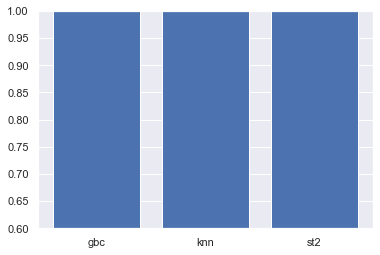

In [826]:
accuracies = [f1_score(y_val, gbc_model.predict(X_val[rfe_variables])), 
              f1_score(y_val, knn_model.predict(X_val[rfe_variables])), 
              f1_score(y_val, st_model_2.predict(X_val[rfe_variables])),
              ]
models = ['gbc','knn','st2']
data_tuples = list(zip(models,accuracies))
data = pd.DataFrame(data_tuples)
data = data.sort_values(1)
plt.bar(data[0], data[1])
plt.ylim(0.6,1.0)
plt.show()

In [827]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, labels_train_st2))
print('F1 Score to the Validation dataset:', f1_score(y_val, labels_val_st2))
print('Kaggle Score: 1.0')


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 1.0
Kaggle Score: 1.0


In [566]:
sub_7 = X_test_norm.copy()
sub_7['Disease'] = labels_test_st2
sub_7 = sub_7[['Disease']]
compression_opts = dict(method='zip',
                        archive_name='Group24_st2_.csv')
sub_7.to_csv('testst2_.zip',
          compression=compression_opts)

#### Random Forest + Bagging Classifier

In [78]:
RFModel = RandomForestClassifier(random_state = 1, criterion = 'entropy', max_depth = 15, max_features = 'auto', ccp_alpha = 0.001, n_estimators=200)
RFModel.fit(X_train[rfe_variables],y_train)
bc_model = BaggingClassifier(base_estimator = ExtraTreesClassifier(), random_state = 43, bootstrap = True,bootstrap_features = True, max_features=0.8, max_samples = 1.0, n_estimators=500)
bc_model.fit(X_train[rfe_variables],y_train) 

estimators = [('rf', RandomForestClassifier(random_state = 1, criterion = 'entropy', max_depth = 15, max_features = 'auto', ccp_alpha = 0.001, n_estimators=200)),
              ('bc', BaggingClassifier(base_estimator = ExtraTreesClassifier(), random_state = 43, bootstrap = True,
                            bootstrap_features = True, max_features=0.8, max_samples = 1.0, n_estimators=500))] 

<ipython-input-78-3498da942b84>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  RFModel.fit(X_train[rfe_variables],y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
<ipython-input-78-3498da942b84>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  bc_model.fit(X_train[rfe_variables],y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [79]:
st_model_3 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)

<ipython-input-79-5fc1c4726523>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  st_model_3 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in

In [844]:
# Stacking - RF + Bagging
st_model_3 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)
labels_train_st3 =st_model_3.predict(X_train[rfe_variables])
labels_val_st3 = st_model_3.predict(X_val[rfe_variables])
labels_test_st3 = st_model_3.predict(X_test[rfe_variables])

In [848]:
metrics(y_train = y_train, pred_train = labels_train_st3, y_val = y_val, pred_val = labels_val_st3)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       353

    accuracy                           1.00       665
   macro avg       1.00      1.00      1.00       665
weighted avg       1.00      1.00      1.00       665

[[312   0]
 [  0 353]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

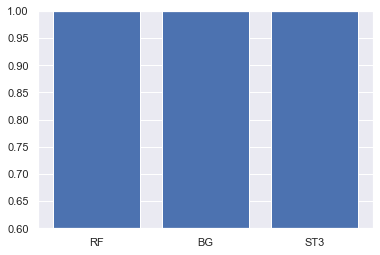

In [851]:
accuracies = [f1_score(y_val, gbc_model.predict(X_val[rfe_variables])), 
              f1_score(y_val, knn_model.predict(X_val[rfe_variables])), 
              f1_score(y_val, st_model_2.predict(X_val[rfe_variables])),
              ]
models = ['RF','BG','ST3']
data_tuples = list(zip(models,accuracies))
data = pd.DataFrame(data_tuples)
data = data.sort_values(1)
plt.bar(data[0], data[1])
plt.ylim(0.6,1.0)
plt.show()

In [852]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, labels_train_st3))
print('F1 Score to the Validation dataset:', f1_score(y_val, labels_val_st3))


F1 Score to the Train dataset: 1.0
F1 Score to the Validation dataset: 1.0


<hr>
<a class="anchor" id="15">
    
# 15. ROC Curves
    
</a>

In [109]:
RFModel = RandomForestClassifier(random_state = 1, criterion = 'entropy', max_depth = 15, max_features = 'auto', ccp_alpha = 0.001, n_estimators=200)
bc_model = BaggingClassifier(base_estimator = ExtraTreesClassifier(), random_state = 43, bootstrap = True,bootstrap_features = True, max_features=0.8, max_samples = 1.0, n_estimators=500)
DTModel = DecisionTreeClassifier(criterion = 'entropy', max_depth = 15, max_features = 6, max_leaf_nodes = None, splitter ='random',random_state = 1)
etc_model = ExtraTreesClassifier(criterion ='entropy', max_depth = 15, max_features = 6, max_samples= None, min_samples_leaf= 1, min_samples_split = 2, n_estimators =100) #random_state=43,n_estimators=1100
gbc_model = GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)
XGBModel = XGBClassifier(random_state = 42, colsample_bytree= 0.5, gamma= 0.01, learning_rate= 0.1, max_depth= 15, min_child_weight= 1, n_estimators= 200, subsample= 1.0)
KNNModel = KNeighborsClassifier(leaf_size = 10, metric = 'manhattan', n_neighbors = 1, weights = 'uniform', n_jobs= -1)

DT = DTModel
RF = RFModel
ETC = etc_model
GBC = gbc_model
XGB = XGBModel
KNN = KNNModel
BC = bc_model
ST = st_model_2
ST2 = st_model_3

<ipython-input-110-665375997327>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  model.fit(X_train[rfe_variables], y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
<ipython-input-110-665375997327>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]
<ipython-input-110-665375997327>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  model.fit(X_train[rfe_variables], y_train)
<ipython-input-110-665375997327>:23

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
<ipython-input-110-665375997327>:71: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]


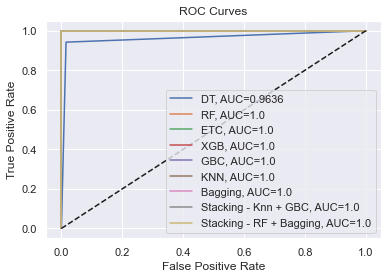

In [110]:
#set up plotting area
plt.figure(0).clf()

#fit Decision Trees Classifier
model = DT
model.fit(X_train[dt_variables], y_train)
y_pred = model.predict_proba(X_val[dt_variables])[:, 1]
fpr, tpr, thresholds  = metrics.roc_curve(y_val, y_pred)
auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
plt.plot(fpr,tpr,label="DT, AUC="+str(auc))

#fit Random Forest Classifier
model = RF
model.fit(X_train[rfe_variables], y_train)
y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]
fpr, tpr, thresholds  = metrics.roc_curve(y_val, y_pred)
auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
plt.plot(fpr,tpr,label="RF, AUC="+str(auc))

#fit Extra Trees Classifier model and plot ROC curve
model = ETC
model.fit(X_train[rfe_variables], y_train)
y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]
fpr, tpr, thresholds  = metrics.roc_curve(y_val, y_pred)
auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
plt.plot(fpr,tpr,label="ETC, AUC="+str(auc))

#fit XGboost model and plot ROC curve
model = XGB
model.fit(X_train[rfe_variables], y_train)
y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
plt.plot(fpr,tpr,label="XGB, AUC="+str(auc))

#fit Gradient boost model and plot ROC curve
model = GBC
model.fit(X_train[rfe_variables], y_train)
y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
plt.plot(fpr,tpr,label="GBC, AUC="+str(auc))

#fit KNN model and plot ROC curve
model = KNN
model.fit(X_train[rfe_variables], y_train)
y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Bagging model and plot ROC curve
model = BC
model.fit(X_train[rfe_variables], y_train)
y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
plt.plot(fpr,tpr,label="Bagging, AUC="+str(auc))

#fit ST model and plot ROC curve
model = ST
model.fit(X_train[rfe_variables], y_train)
y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
plt.plot(fpr,tpr,label="Stacking - Knn + GBC, AUC="+str(auc))

#fit ST2 model and plot ROC curve
model = ST2
model.fit(X_train[rfe_variables], y_train)
y_pred = model.predict_proba(X_val[rfe_variables])[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
plt.plot(fpr,tpr,label="Stacking - RF + Bagging, AUC="+str(auc))


#add legend
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.title('ROC Curves')
plt.plot([0, 1], [0, 1], 'k--')


<hr>
<a class="anchor" id="16">
    
# 16. Candidate Models
    
</a>

In [116]:
X_train = X_train_norm.copy()
X_test = X_test_norm.copy() 
y_train = y_train.copy()

In [870]:
# Stacking - Knn + GBC
st_model_2 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)
labels_train_st2 =st_model_2.predict(X_train[rfe_variables])
labels_test_st2 = st_model_2.predict(X_test[rfe_variables])

#Kaggle - 0.98901

In [681]:
sub_2 = X_test_norm.copy()
sub_2['Disease'] = labels_test_st2
sub_2 = sub_2[['Disease']]
compression_opts = dict(method='zip',
                        archive_name='Group24_Version95.csv')
sub_2.to_csv('testst2.zip',
          compression=compression_opts)

In [682]:
RFModel = RandomForestClassifier(random_state = 1, criterion = 'entropy', max_depth = 15, max_features = 'auto', ccp_alpha = 0.001, n_estimators=200)
bc_model = BaggingClassifier(base_estimator = ExtraTreesClassifier(), random_state = 43, bootstrap = True,
                            bootstrap_features = True, max_features=0.8, max_samples = 1.0, n_estimators=500)

In [683]:
RFModel.fit(X_train[rfe_variables],y_train)
bc_model.fit(X_train[rfe_variables],y_train) 

estimators = [('rf', RandomForestClassifier(random_state = 1, criterion = 'entropy', max_depth = 15, max_features = 'auto', ccp_alpha = 0.001, n_estimators=200)),
              ('bc', BaggingClassifier(base_estimator = ExtraTreesClassifier(), random_state = 43, bootstrap = True,
                            bootstrap_features = True, max_features=0.8, max_samples = 1.0, n_estimators=500))] 

In [812]:
# Stacking - RF + Bagging
st_model_3 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)
labels_train_st3 =st_model_3.predict(X_train[rfe_variables])
labels_test_st3 = st_model_3.predict(X_test[rfe_variables])

#Kaggle - 1.0

In [80]:
def compare_kfold_scores(models, X, y):
    """
    Graphically compare the scores of multiple models using k-fold cross-validation.
    
    Parameters
    ----------
    models : list
        A list of scikit-learn model objects.
    X : pandas DataFrame
        The feature data.
    y : pandas Series
        The target data.
    
    Returns
    -------
    None
    
    """
    # Set up the plot
    fig, ax = plt.subplots(figsize=(20, 22))
    ax.set_ylabel('Score')
    ax.set_xlabel('Model')
    ax.set_title('Model Comparison using K-fold Cross-Validation')
    
    # Use a repeated k-fold cross-validation method
    method = KFold(n_splits=10)
    
    # Iterate through each model
    for i, model in enumerate(models):
        train_scores = []
        validation_scores = []
        
        # Use cross-validation to calculate the scores for each model
        for train_index, test_index in method.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train, y_train)
            train_scores.append(model.score(X_train, y_train))
            validation_scores.append(model.score(X_test, y_test))
        
        # Plot the mean scores for each model
        ax.bar(i - 0.2, np.mean(train_scores), width=0.4, color='lightsteelblue')
        ax.bar(i + 0.2, np.mean(validation_scores), width=0.4, color='cornflowerblue')
    
    # Add the model names as labels to the plot
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels([type(model).__name__ for model in models])
    
    # Add a legend to the plot
    blue_patch = mpatches.Patch(color='lightsteelblue', label='Train')
    orange_patch = mpatches.Patch(color='cornflowerblue', label='Validation')
    plt.legend(handles=[blue_patch, orange_patch])
    
    plt.show()


In [81]:
RFModel = RandomForestClassifier(random_state = 1, criterion = 'entropy', max_depth = 15, max_features = 'auto', ccp_alpha = 0.001, n_estimators=200)
bc_model = BaggingClassifier(base_estimator = ExtraTreesClassifier(), random_state = 43, bootstrap = True,bootstrap_features = True, max_features=0.8, max_samples = 1.0, n_estimators=500)
DTModel = DecisionTreeClassifier(criterion = 'entropy', max_depth = 15, max_features = 6, max_leaf_nodes = None, splitter ='random',random_state = 1)
etc_model = ExtraTreesClassifier(criterion ='entropy', max_depth = 15, max_features = 6, max_samples= None, min_samples_leaf= 1, min_samples_split = 2, n_estimators =100) #random_state=43,n_estimators=1100
gbc_model = GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)
XGBModel = XGBClassifier(random_state = 42, colsample_bytree= 0.5, gamma= 0.01, learning_rate= 0.1, max_depth= 15, min_child_weight= 1, n_estimators= 200, subsample= 1.0)
KNNModel = KNeighborsClassifier(leaf_size = 10, metric = 'manhattan', n_neighbors = 1, weights = 'uniform', n_jobs= -1)

DT = DTModel
RF = RFModel
ETC = etc_model
GBC = gbc_model
XGB = XGBModel
KNN = KNNModel
BC = bc_model
ST = st_model_2
ST2 = st_model_3

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklear

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\a

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklear

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklear

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


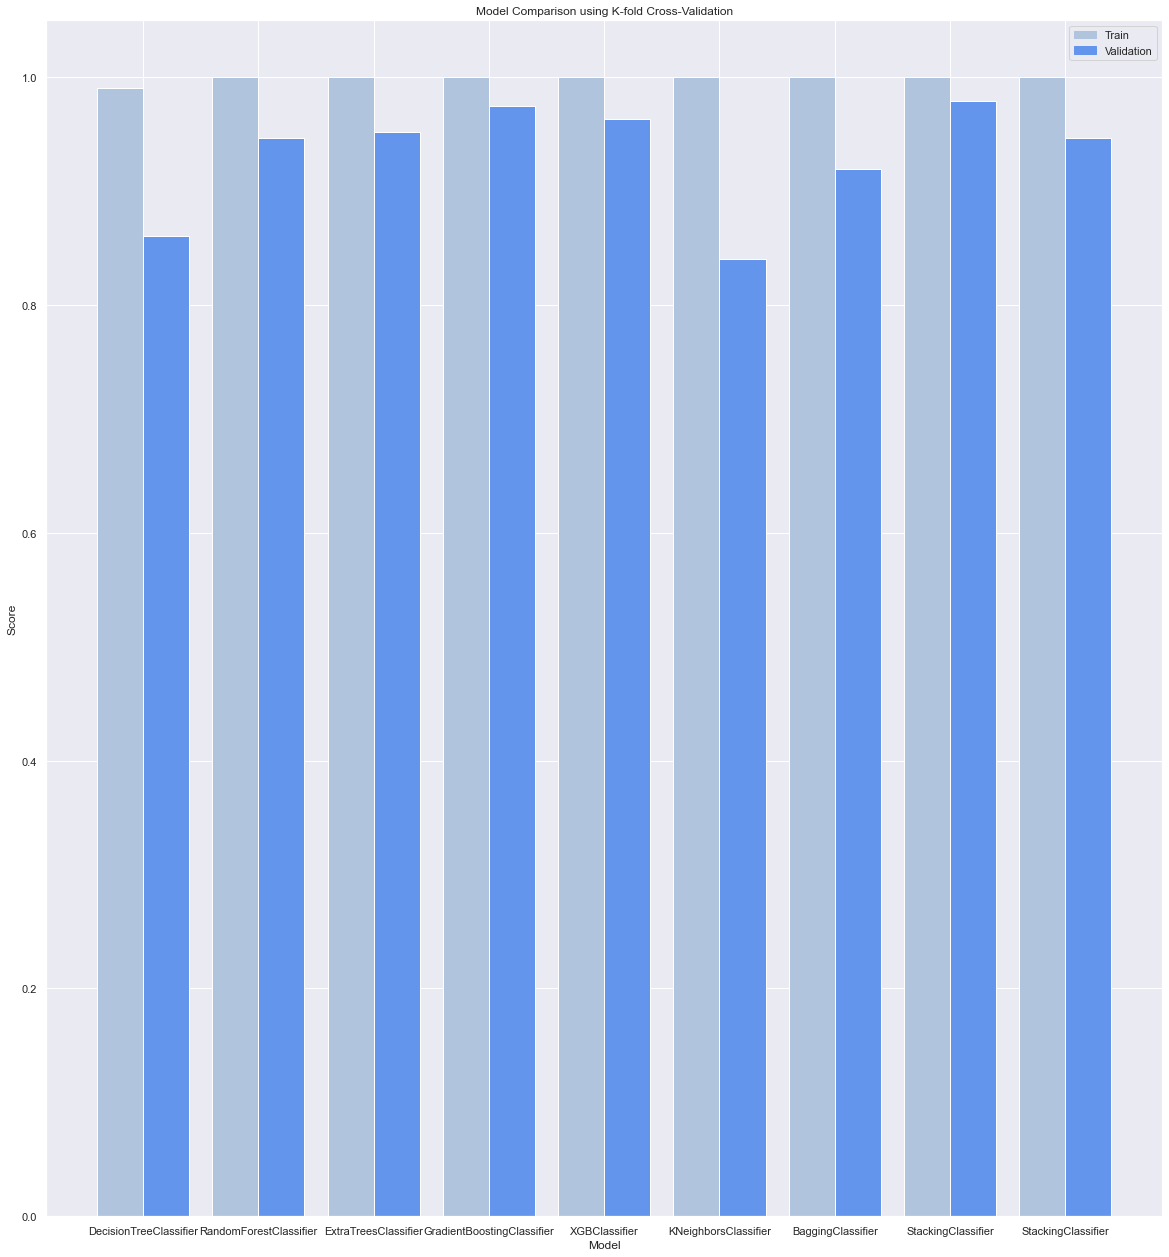

In [82]:
# Create a list of model objects
models = [DT,RF,ETC,GBC,XGB,KNN,BC,ST,ST2]
# Use the compare_kfold_scores function to compare the models
compare_kfold_scores(models, X_train, y_train)

In [678]:
#BC model
#bc_model = BaggingClassifier(base_estimator = ExtraTreesClassifier(), random_state = 43, bootstrap = True,
#                            bootstrap_features = True, max_features=0.8, max_samples = 1.0, n_estimators=500)
#bc_model.fit(X_train[rfe_variables], y_train)
#labels_train_bc =bc_model.predict(X_train[rfe_variables])
#labels_test_bc = bc_model.predict(X_test[rfe_variables])
#
##Kaggle- 1.0

In [679]:
#sub_1 = X_test_norm.copy()
#sub_1['Disease'] = labels_test_bc 
#sub_1 = sub_1[['Disease']]
#compression_opts = dict(method='zip',
#                        archive_name='Group24_Version94.csv')
#sub_1.to_csv('testBC.zip',
#          compression=compression_opts)

In [779]:
# GBC Model
#gbc_model = GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)
#gbc_model.fit(X_train[rfe_variables], y_train)
#labels_train_gbc =gbc_model.predict(X_train[rfe_variables])
#labels_test_gbc = gbc_model.predict(X_test[rfe_variables])

##Kaggle - 1.0

In [746]:
#sub_4 = X_test_norm.copy()
#sub_4['Disease'] = labels_test_gbc 
#sub_4 = sub_4[['Disease']]
#compression_opts = dict(method='zip',
#                        archive_name='Group24_Version98.csv')
#sub_4.to_csv('testGBC.zip',
#          compression=compression_opts)

In [814]:
#GBC + XGBoost
#gbc_model.fit(X_train[rfe_variables],y_train)
#XGBModel.fit(X_train[rfe_variables],y_train) 

#estimators = [('gbc', GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)),
#              ('xgb', XGBClassifier(random_state = 42, colsample_bytree= 0.5, gamma= 0.01, learning_rate= 0.1, max_depth= 15, min_child_weight= 1, n_estimators= 200, subsample= 1.0))]

In [815]:
# Stacking - GBC + XGB

#st_model_4 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)
#labels_train_st4 =st_model_4.predict(X_train[rfe_variables])
#labels_test_st4 = st_model_4.predict(X_test[rfe_variables])

#Kaggle - 1.0

In [816]:
#sub_5 = X_test_norm.copy()
#sub_5['Disease'] = labels_test_st4 
#sub_5 = sub_5[['Disease']]
#compression_opts = dict(method='zip',
                        #archive_name='Group24_Version99.csv')
#sub_5.to_csv('testst4.zip',
#         compression=compression_opts)

In [83]:
def get_kfold_scores(model, X, y, n_splits=10):
    kfold = KFold(n_splits=n_splits)

    train_scores = []
    val_scores = []

    for train_index, val_index in kfold.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        val_scores.append(model.score(X_val, y_val))

    return (np.mean(train_scores), np.mean(val_scores))

In [85]:
#model = st_model_2
## Get the training and validation scores
#train_score, val_score = get_kfold_scores(model, X_train[rfe_variables], y_train)
#
## Print the scores
#print("Training score:", train_score)
#print("Validation score:", val_score)

#Validation score: 0.9821811100292113

<ipython-input-85-390bf94ef35c>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_score, val_score = get_kfold_scores(model, X_train[rfe_variables], y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_lo

C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1

Training score: 1.0
Validation score: 0.9821811100292113


In [87]:
# Stacking - GBC + KNN
#gbc_model = GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)
#knn_model = KNeighborsClassifier(leaf_size = 10, metric = 'manhattan', n_neighbors = 1, weights = 'uniform')
#
#gbc_model.fit(X_train[rfe_variables],y_train)
#knn_model.fit(X_train[rfe_variables],y_train) 
#
#estimators = [('gbc',GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)),
#              ('knn', KNeighborsClassifier(leaf_size = 10, metric = 'manhattan', n_neighbors = 1, weights = 'uniform')) ] 
#
#st_model_2 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)
#labels_train_st2 =st_model_2.predict(X_train[rfe_variables])
#labels_test_st2 = st_model_2.predict(X_test[rfe_variables])

<ipython-input-87-b78c908b4e70>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gbc_model.fit(X_train[rfe_variables],y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
<ipython-input-87-b78c908b4e70>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  knn_model.fit(X_train[rfe_variables],y_train)
<ipython-input-87-b78c908b4e70>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  st_model_2 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train[rfe_variables], y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\s

In [88]:
sub_5 = X_test_norm.copy()
sub_5['Disease'] = labels_test_st2 
sub_5 = sub_5[['Disease']]
compression_opts = dict(method='zip',
                        archive_name='Group24_Version100.csv')
sub_5.to_csv('testst2.zip',
          compression=compression_opts)

<hr>
<a class="anchor" id="17">
    
# 17. Final Model
    
</a>

In [92]:
gbc_model = GradientBoostingClassifier(random_state=1,learning_rate = 0.1, loss='deviance',max_depth = 5, n_estimators = 200)

gbc_model.fit(X_train[rfe_variables],y_train)


labels_train_gbc =gbc_model.predict(X_train[rfe_variables])
labels_test_gbc = gbc_model.predict(X_test[rfe_variables])

<ipython-input-92-8bb2dc5c4a78>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gbc_model.fit(X_train[rfe_variables],y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
<ipython-input-92-8bb2dc5c4a78>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  labels_train_gbc =gbc_model.predict(X_train[rfe_variables])
<ipython-input-92-8bb2dc5c4a78>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  labels_test_gbc = gbc_model.predict(X_test[rfe_variables])


In [93]:
sub_5 = X_test_norm.copy()
sub_5['Disease'] = labels_test_gbc
sub_5 = sub_5[['Disease']]
compression_opts = dict(method='zip',
                        archive_name='Group24_Version101.csv')
sub_5.to_csv('testgbc.zip',
          compression=compression_opts)

In [84]:
model = gbc_model
# Get the training and validation scores
train_score, val_score = get_kfold_scores(model, X_train[rfe_variables], y_train)

# Print the scores
print("Training score:", train_score)
print("Validation score:", val_score)

<ipython-input-84-b2615d13dbc3>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_score, val_score = get_kfold_scores(model, X_train[rfe_variables], y_train)
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\alvar\anaconda3\envs\project\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_lo

Training score: 1.0
Validation score: 0.9770691333982473
